In [1]:
# Version 2.1 - new PN Activity representation (binomial dist.)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import pickle
import scipy.stats as st
import copy

# read csv 
df = pd.read_csv('connectivity matrix table 1.csv') # matrix of connections between neurons

# FUNCTIONS

# Filters dataframe based on neuron type. 
# Establishes a synapse threshold of greater than 1
# data - the dataframe
# col_substr - regex to select for substrings that represent neuron type in columns
# row_substr - regex to select for substrings that represent neuron type in rows
# row_header - header for indices
def filter_neuron_types(data, col_substr, row_substr, idx_header):
    first_column = df.iloc[:, 0] # gets first column to use as row indices
    # columns
    new_df = data.filter(regex=col_substr, axis='columns') 
    
    # rows
    new_df.insert(0, idx_header, first_column, True) # inserts column with row labels into the new dataframe
    new_df.set_index(idx_header, inplace=True) # sets inserted column as dataframe indicies
    new_df = new_df.filter(regex=row_substr, axis='index')
    
    # establishing a threshold of num synapses > 1 to count as a connection
    num_rows = len(new_df)
    # loops thru rows of new_df
    for i in range(num_rows):
        row = new_df.iloc[i] # gets row
        new_row = np.where(row == 1, 0, row) # if synaspse num = 1, change to 0
        new_df.iloc[i] = new_row
    
    return new_df

# Normalizes weights by column's sum in a pandas df
# df - dataframe
# sum_of_w - the sum of the weights
def normalize_weights_df(df, sum_of_w):
    col = len(df.columns)
    #df.iloc[:,0:col] = df.iloc[:,0:col].apply(lambda x: x / np.linalg.norm(x), axis=0)
    #df = normalize(df, axis=0, norm='l1') # normalize by column to sum of 1
    for c in range(col):
        w = df.iloc[:,c]
        s = sum(abs(w)) # sum of column
        if (s != 0):
            df.iloc[:,c] = [i/s for i in w]
    return sum_of_w * df

# Normalizes weights by column's sum in a numpy array
# arr - numpy array
# sum_of_w - the sum of the weights
def normalize_weights_np(arr, sum_of_w):
    col = len(arr[0])
    #df.iloc[:,0:col] = df.iloc[:,0:col].apply(lambda x: x / np.linalg.norm(x), axis=0)
    #df = normalize(df, axis=0, norm='l1') # normalize by column to sum of 1
    for c in range(col):
        w = arr[:,c]
        s = sum(abs(w)) # sum of column
        if (s != 0):
            arr[:,c] = [i/s for i in w]
    return sum_of_w * arr

# Sets the bias for a single KC so that the KC fires 5% of 
# the time in response to any odor
# inputs - array of all points from all odors
# weights - array of weights (aka synapses) for a single KC
def set_kc_bias(inputs, weights):
    I = len(inputs)
    bias = 0
    
    kc_output = np.zeros((I,)) # array to store output values
    
    # loops thru all inputs and calculates and stores the KC output value
    for i in range(I):
        point = inputs[i]
        #print("point:\n{}, length: {}".format(point, len(point)))

        # equation
        x = np.dot(point, weights) # no bias yet (theta=0)
        #print("output value: {}".format(x))

        kc_output[i] = x  # add output value to output array
    
    kc_output.sort() # sort output values in ascending order
    #print("output values of single KC after sorting:\n{} \nlength: {}".format(kc_output, len(kc_output)))
    idx = int(0.05 * len(kc_output)) # getting index for the threshold that'll provide a 5% firing rate (out of 5000, this is the 251th output value with index of 250)
    #print("index: ", idx)
    bias = kc_output[idx]
    #print("bias: ", bias)
    
    return bias

# Calculates output of KC layer
# weights - weights (num of synapses) for connections from PNs to KCs
# biases - biases
# inputs - inputs from PNs
def build_pn_to_kc(inputs, weights, biases):
    
    # equation
    x1 = np.dot(inputs, weights) + biases # matrix multiplication to multiply inputs by weights
    #print("after matrix multiplication:\n{}, \nlength: {}".format(x1, len(x1)))

    # thresholding
    x1 = np.where(x1 > 0, 1, 0)
    #print("after thresholding:\n{}, \nlength: {}".format(x1, len(x1)))
    
    return x1

# Calculates output of MBON layer
# weights - weights (num of synapses) from KC to MBON
# inputs - inputs from KCs
# bias - biases
def build_kc_to_mbon(inputs, weights, bias):
    
    # equation
    x2 = np.dot(inputs, weights) + bias
    #print("after matrix multiplication:\n{}, \nnum of rows: {}".format(x2, len(x2)))

    # thresholding
    x2 = np.where(x2 > 0, 1, 0)
    #print("after thresholding:\n{}, \nlength: {}".format(x2, len(x2)))
    
    return x2

# Randomly prunes a certain number of pre-synaptic KCs and returns the new weight table (df) and the names of KCs with
# connections set to zero in each MBON
# df - synapse table
# num - number of KCs to remove
def prune_rand_kcs(df, num):
    num_mbons = len(df.columns)
    kc_names = []
    
    # loop thru each column = MBON
    for m in range(num_mbons):        
        idxs_with_conn = np.asarray(np.where(df.iloc[:,m] > 0)).flatten() # gets indicies where there is a connection to a KC
        
        # randomly select KC connections to be removed
        s = num
        if (len(idxs_with_conn) < num): # if less KC connections than num to remove, then remove all 
            s = len(idxs_with_conn)
        indicies = np.random.choice(a=idxs_with_conn, size=s, replace=False)
        
        kc_names.append(df.index[indicies]) # record names of KCs
        
        for i in indicies:
            df.iloc[i, m] = 0
    
    df = df.to_numpy()
    return df, kc_names

# Randomly ablates a certain number of pre-synaptic KCs and returns the new weight table (df) and the names of KCs with
# connections set to zero in each MBON
# df - synapse table
# num - number of KCs to remove
def ablate_rand_kcs(df, num):
    num_mbons = len(df.columns)
    num_kcs = len(df)
    kc_names = []    
        
    # randomly select KC connections to be removed
    indicies = random.choice(num_kcs, size=num, replace=False)
    kc_names.append(df.index[indicies]) # record names of KCs
    # sets each row (= each KC) in indices to zero
    for i in indicies:
        df.iloc[i, :] = 0
    
    df = df.to_numpy()
    return df, kc_names

# Sets the all synaptic weight values of the top certain number of KCs to zero. Returns new weight table with
# KCs removed and a list of names of the KCs removed
# prev_w - weight table from previous run (np arr)
# curr_w - current weight table (df as input, return as np array)
# num - the number of KCs' connections to remove
# run - the realization (eg. 0, 1, 2...)
def ablate_top_kcs(prev_w, curr_w, num, run):
    sum_weights = abs(prev_w[run]).sum(axis=1) # total absolute value of final weights for each KC 
    top_weight_idx = np.argpartition(sum_weights, -1*num)[-1*num:]
    
    # record which KCs are removed
    kc_names = list(curr_w.index[top_weight_idx])
    
    curr_w = curr_w.to_numpy()
    curr_w[top_weight_idx,:] = 0 # sets weight values of KCs to be removed to zero
    
    return curr_w, kc_names

In [2]:
# FILTER DATA FOR PNs (rows) to KCs (columns) CONNECTIONS -> pn_kc
pn_kc = filter_neuron_types(df, "(?=.*KC)(?=.*left)", "(?=.*PN)(?=.*left)", "Presynaptic PNs") # filter w/ regex PNs and KCs

# normalize weights
pn_kc = normalize_weights_df(pn_kc, 1)
#pn_kc = pn_kc.fillna(0)

pn_kc

1 claw KC left  1 claw KC left.1  1 claw KC left.2  \
Presynaptic PNs                                                                 
1a PN left                            0.0               0.0               0.0   
13a PN left                           0.0               0.0               0.0   
22c PN left                           0.0               0.0               0.0   
24a PN left                           0.0               0.0               0.0   
30a PN left                           0.0               0.0               0.0   
33a PN left                           0.0               0.0               0.0   
35a PN bilateral left                 0.0               0.0               0.0   
42a PN left                           0.0               0.0               0.0   
42b PN left                           0.0               0.0               0.0   
45a PN left                           0.0               0.0               0.0   
45b PN left                           1.0               0.0               0.0   
47a & 33b PN left                     0.0               0.0               0.0   
49a PN left                           0.0               0.0               1.0   
59a PN left                           0.0               0.0               0.0   
63a PN left                           0.0               0.0               0.0   
67b PN left                           0.0               1.0               0.0   
74a PN left                           0.0               0.0               0.0   
82a PN left                           0.0               0.0               0.0   
83a PN left                           0.0               0.0               0.0   
85c PN left                           0.0               0.0               0.0   
94a & 94b PN left                     0.0               0.0               0.0   
Gustatory PN 1 left                   0.0               0.0               0.0   
Gustatory PN 2 left                   0.0               0.0               0.0   
Gustatory PN 3 left                   0.0               0.0               0.0   
Gustatory PN 4 left                   0.0               0.0               0.0   
Multiglomerular PN 1 left             0.0               0.0               0.0   
Multiglomerular PN 2 left             0.0               0.0               0.0   
Multiglomerular PN 3 left             0.0               0.0               0.0   
Multiglomerular PN 4 left             0.0               0.0               0.0   
Multiglomerular PN 5 left             0.0               0.0               0.0   
Unkown PN 1 left                      0.0               0.0               0.0   
Unkown PN 2 left                      0.0               0.0               0.0   
Thermo PN 1 left                      0.0               0.0               0.0   
Thermo PN 2 left                      0.0               0.0               0.0   
Thermo PN 3 left                      0.0               0.0               0.0   
Thermo PN 4 left                      0.0               0.0               0.0   
Vision PN 1 left                      0.0               0.0               0.0   
Thermo PN 6 left                      0.0               0.0               0.0   
Thermo PN 7 left                      0.0               0.0               0.0   
Thermo PN 8 left                      0.0               0.0               0.0   

                           1 claw KC left.3  1 claw KC left.4  \
Presynaptic PNs                                                 
1a PN left                              0.0          0.000000   
13a PN left                             0.0          0.105263   
22c PN left                             0.0          0.000000   
24a PN left                             0.0          0.000000   
30a PN left                             0.0          0.000000   
33a PN left                             0.0          0.000000   
35a PN bilateral left                   0.0          0.894737   
42a PN left                            

In [3]:
# FILTER DATA FOR KCs TO MBONs CONNECTIONS -> kc_to_mbon
kc_mbon = filter_neuron_types(df, "(?=.*MBON)(?=.*left)", "(?=.*KC)(?=.*left)", "Presynaptic KCs") # filter w/ regex for KCs and MBON lefts

# take out MBONs with no KC connections
kc_mbon = kc_mbon.drop(kc_mbon.loc[:, (kc_mbon.sum(axis=0) == 0)], axis=1)

# adding a fictional MBON
fict_weights = np.full(len(kc_mbon), 0.1) # initializing all weights at 0.1
kc_mbon['MBON-fict'] = fict_weights

# normalizing weights
kc_mbon = kc_mbon.fillna(0)
kc_mbon_orig = kc_mbon.copy(deep=True)
kc_mbon = normalize_weights_df(kc_mbon, 1)

kc_mbon

MBON-a1 left  MBON-a2 left  MBON-b1 left  MBON-b2 left  \
Presynaptic KCs                                                           
1 claw KC left       0.014286      0.011416      0.036723      0.019663   
1 claw KC left       0.028571      0.009132      0.042373      0.042135   
1 claw KC left       0.035714      0.009132      0.028249      0.039326   
1 claw KC left       0.039286      0.011416      0.067797      0.056180   
1 claw KC left       0.010714      0.006849      0.033898      0.022472   
...                       ...           ...           ...           ...   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   

                 MBON-c1 left  MBON-d1 left  MBON-e1 left  MBON-e2 left  \
Presynaptic KCs                                                           
1 claw KC left       0.034662      0.024450      0.033386      0.052632   
1 claw KC left       0.023397      0.031785      0.027027      0.022556   
1 claw KC left       0.019064      0.022005      0.019078      0.030075   
1 claw KC left       0.033795      0.022005      0.030207      0.045113   
1 claw KC left       0.054593      0.034230      0.012719      0.000000   
...                       ...           ...           ...           ...   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   

                 MBON-g1 left  MBON-g2 left  MBON-h1 left  MBON-h2 left  \
Presynaptic KCs                                                           
1 claw KC left       0.015595      0.014894      0.020761      0.025974   
1 claw KC left       0.031189      0.023404      0.006920      0.018182   
1 claw KC left       0.021442      0.019149      0.020761      0.023377   
1 claw KC left       0.025341      0.008511      0.024221      0.036364   
1 claw KC left       0.007797      0.023404      0.031142      0.018182   
...                       ...           ...           ...           ...   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   

                 MBON-i1 left  MBON-k1 left  MBON-m1 left  MBON-n1 left  \
Presynaptic KCs                                                           
1 claw KC left       0.048128      0.000000      0.028249           0.0   
1 claw KC left       0.026738      0.000000      0.000000           0.0   
1 claw KC left       0.053476      0.034483      0.011299           0.0   
1 claw KC left       0.026738      0.000000      0.016949           0.0   
1 claw KC left       0.026738      0.022989      0.028249           0.0   
...                       ...           ...           ...           ...   
young KC left        0.000000      0.000000      0.000000           0.0   
young KC left        0.000000      0.000000      0.000000           0.0   
young KC left        0.000000      0.000000      0.000000           0.0   
young KC left        0.000000      0.000000      0.000000           0.0   
young KC left        0.000000      0.000000      0.000000           0.0   

                 MBON-o1 left  MBON-q1 left  MBON-fict  
Presynaptic KCs                                         

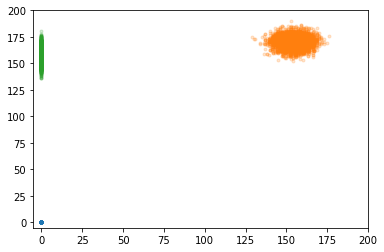

Realization 1: DONE


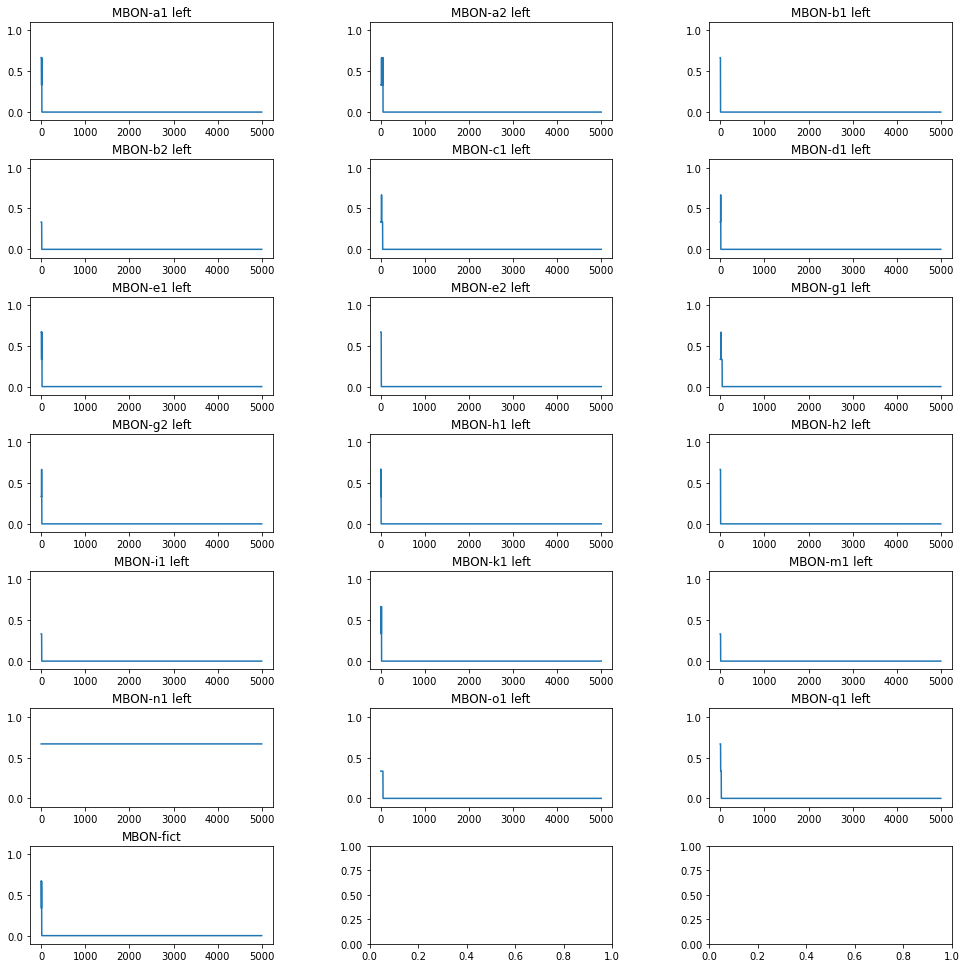

Realization 2: DONE


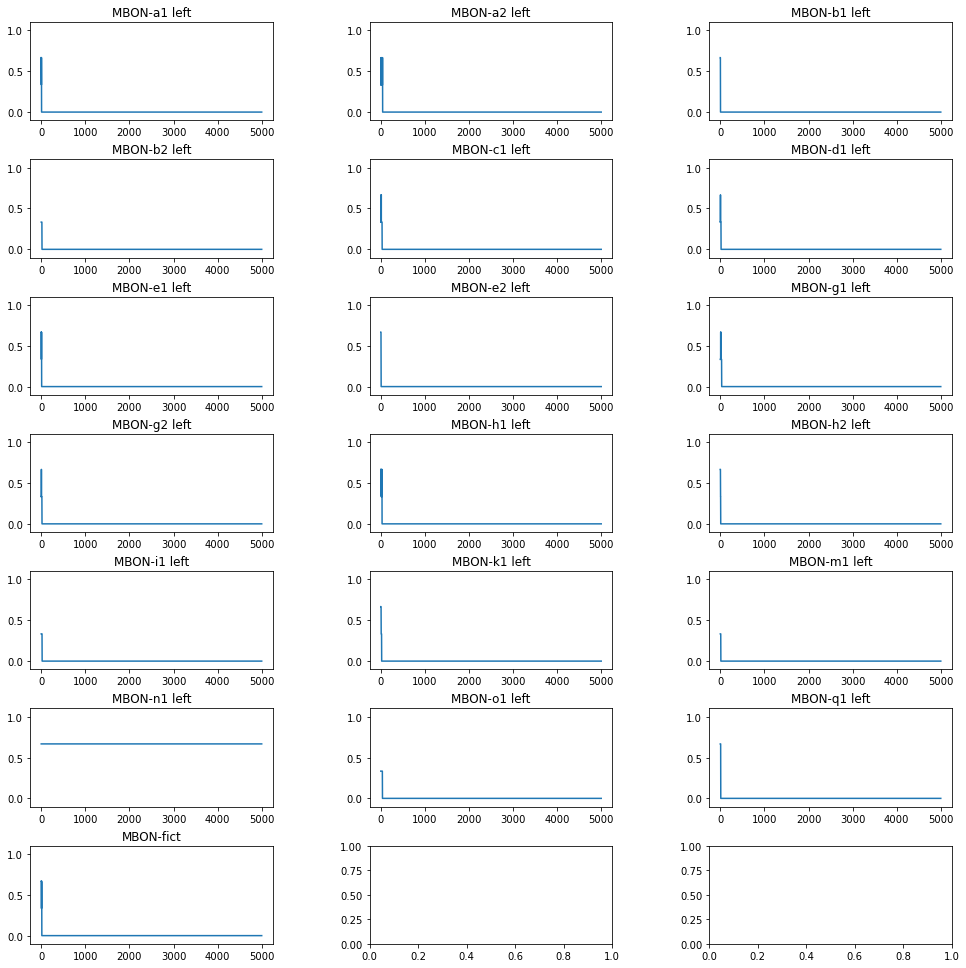

Realization 3: DONE


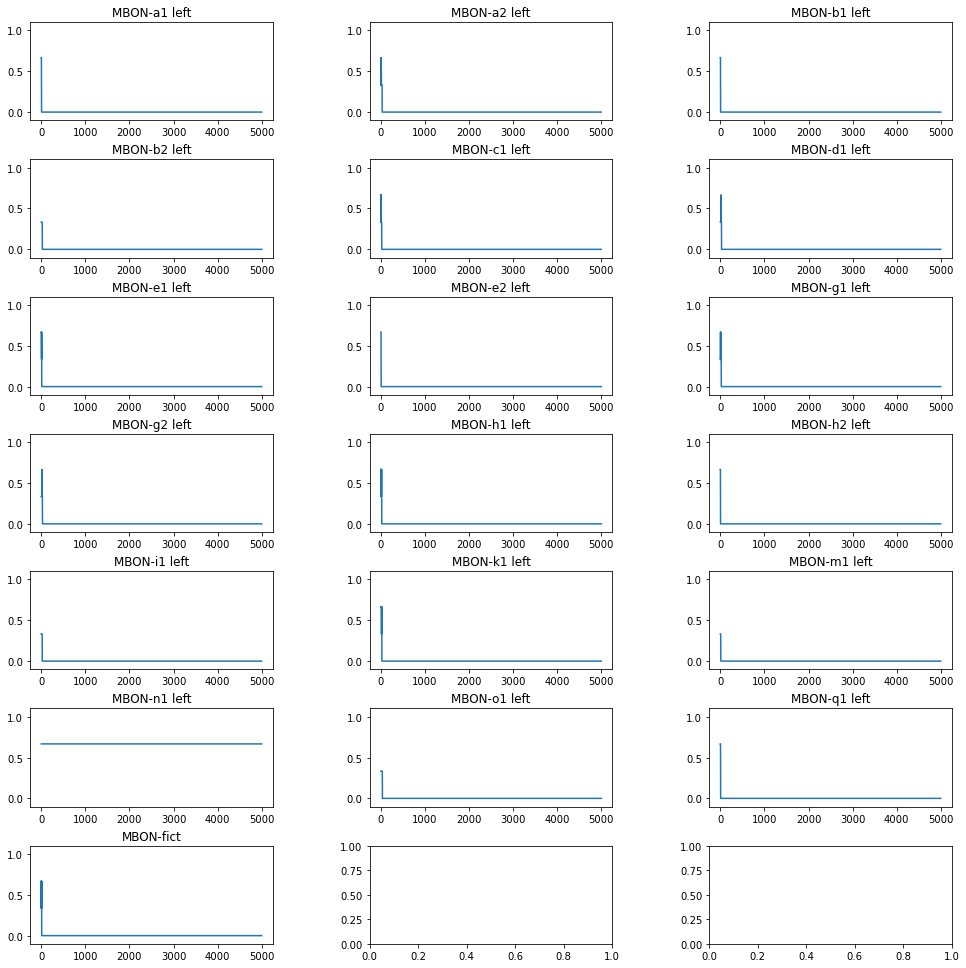

Realization 4: DONE


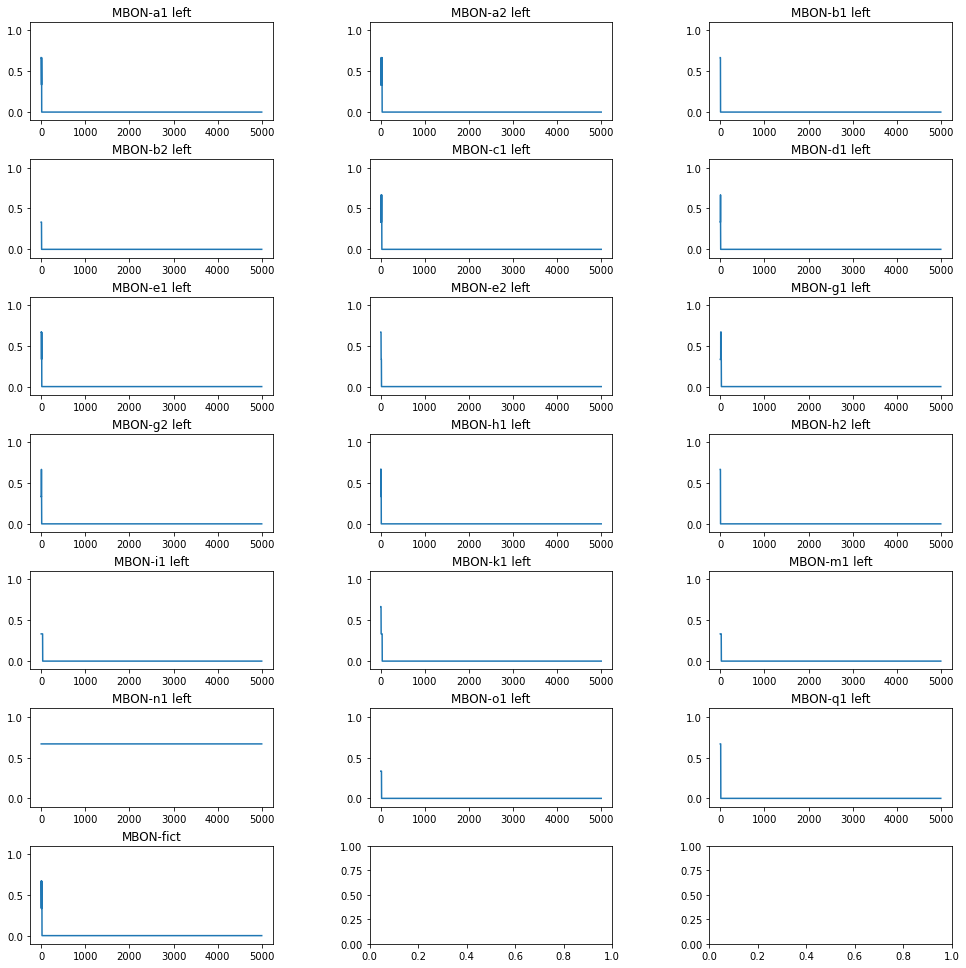

Realization 5: DONE


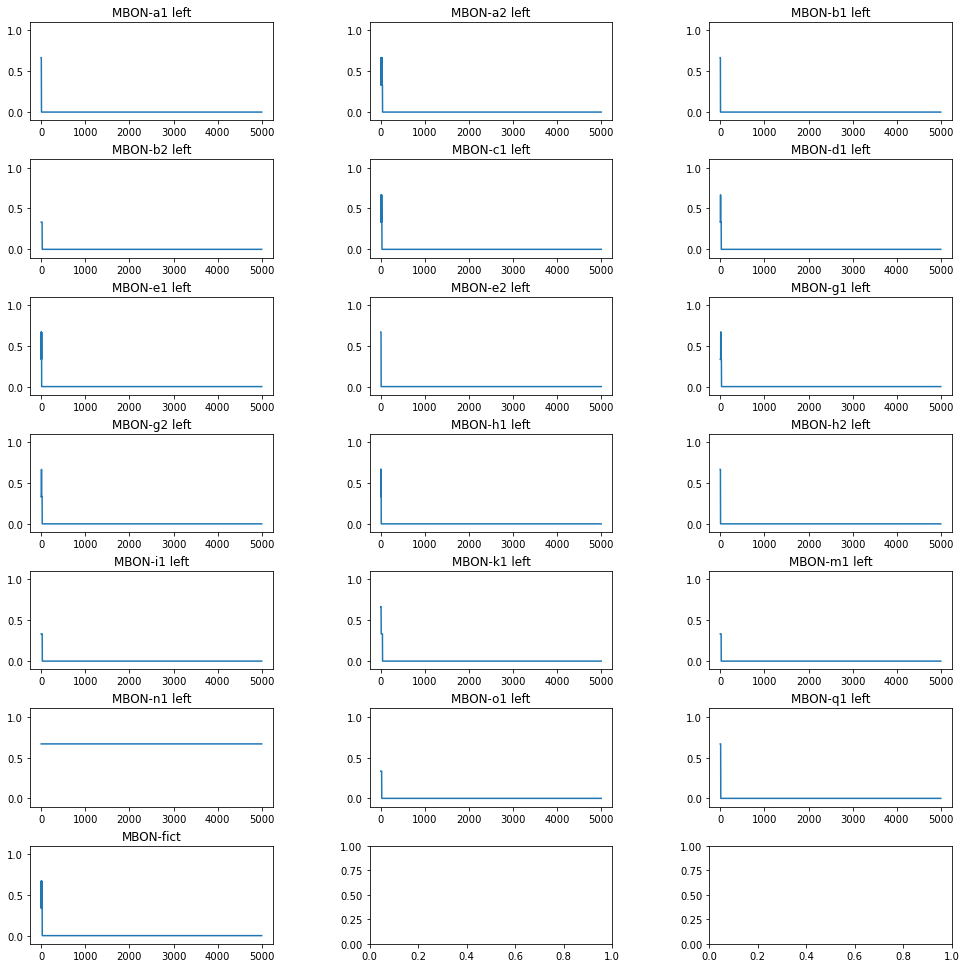

Realization 6: DONE


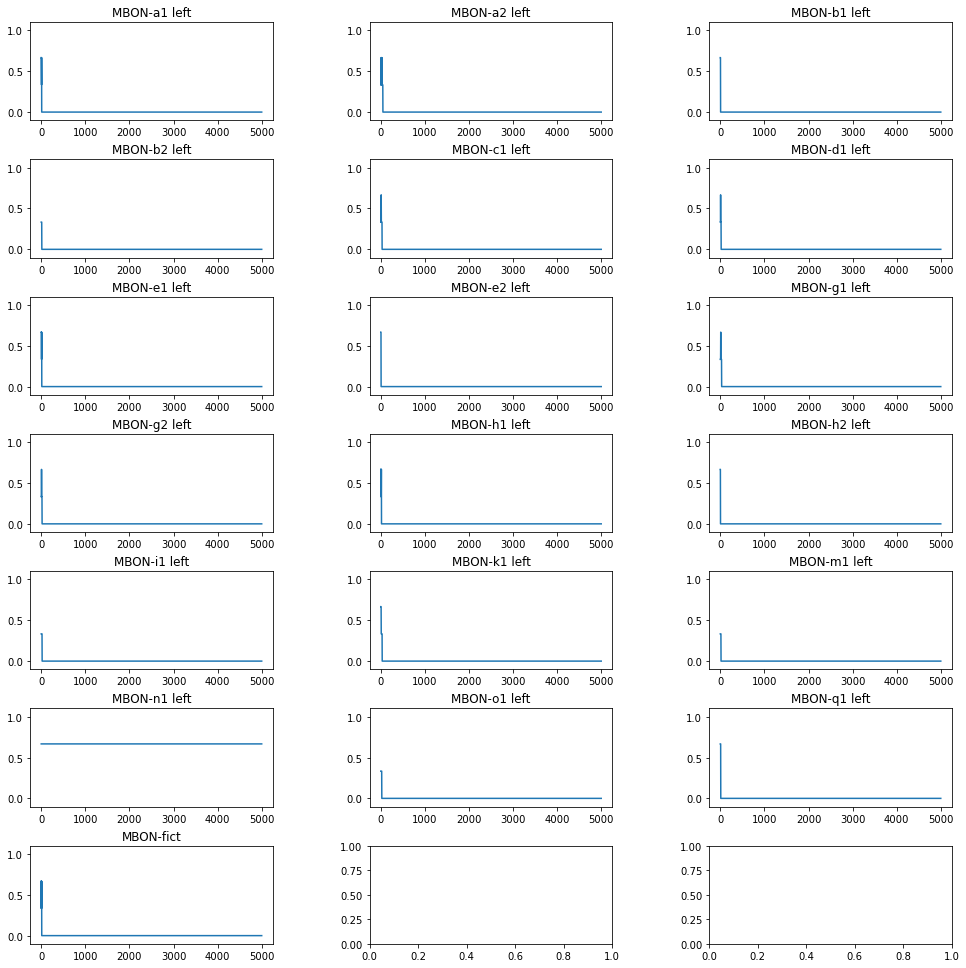

Realization 7: DONE


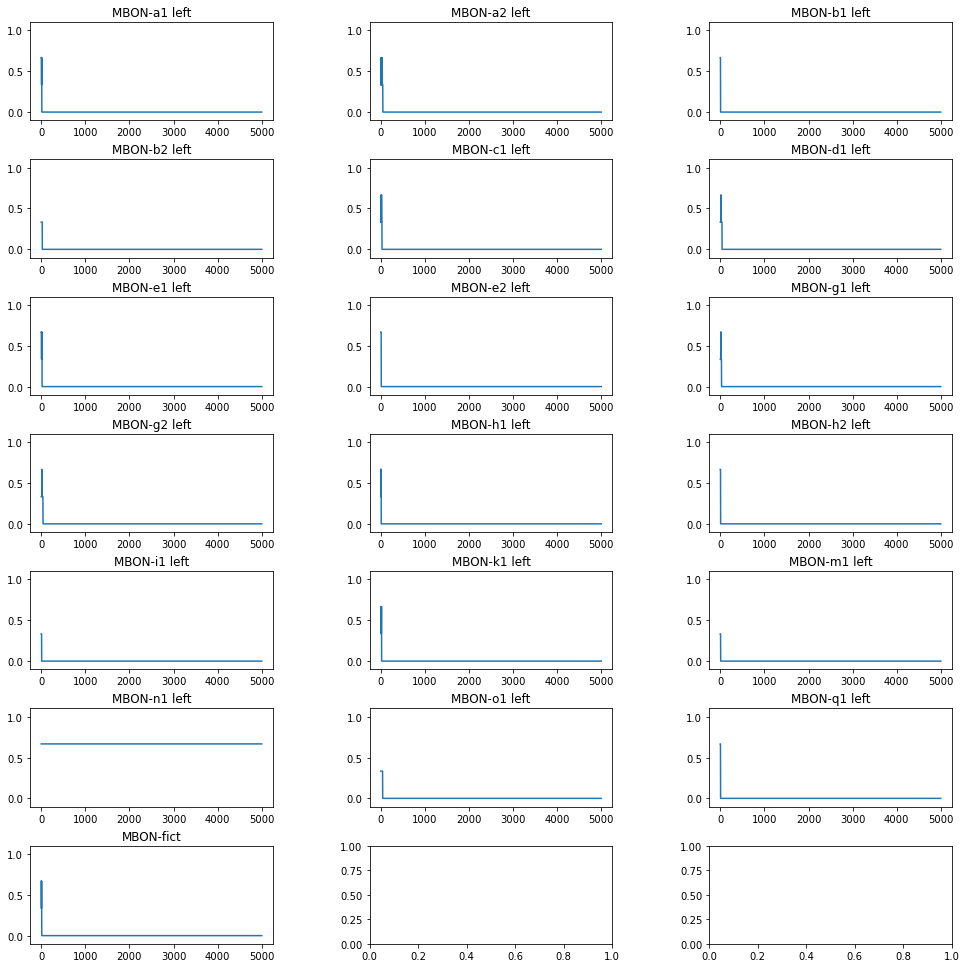

Realization 8: DONE


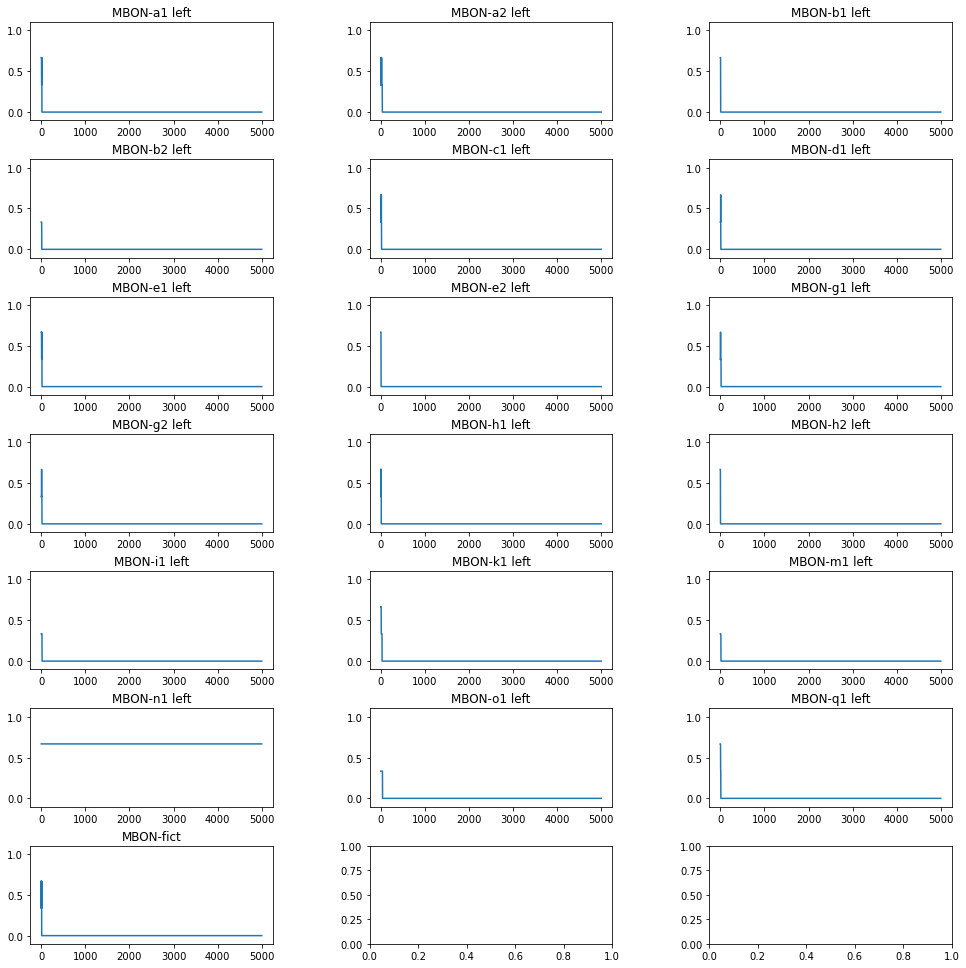

Realization 9: DONE


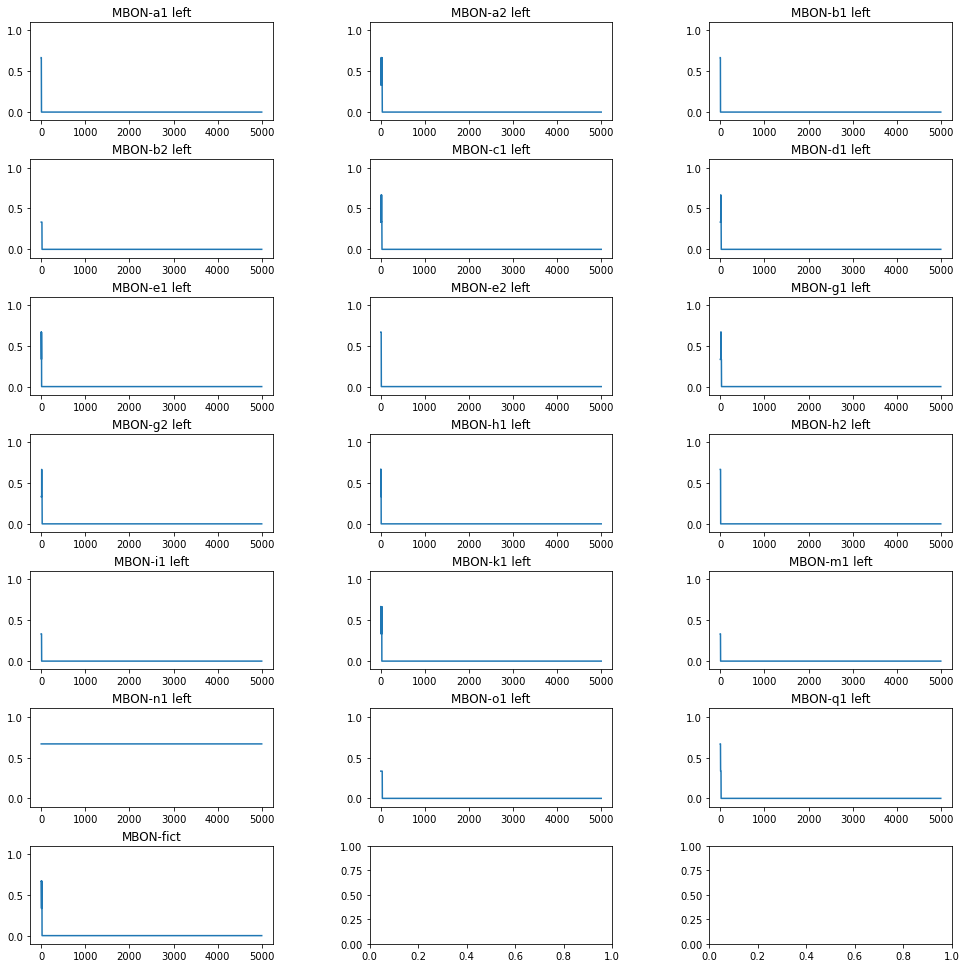

Realization 10: DONE


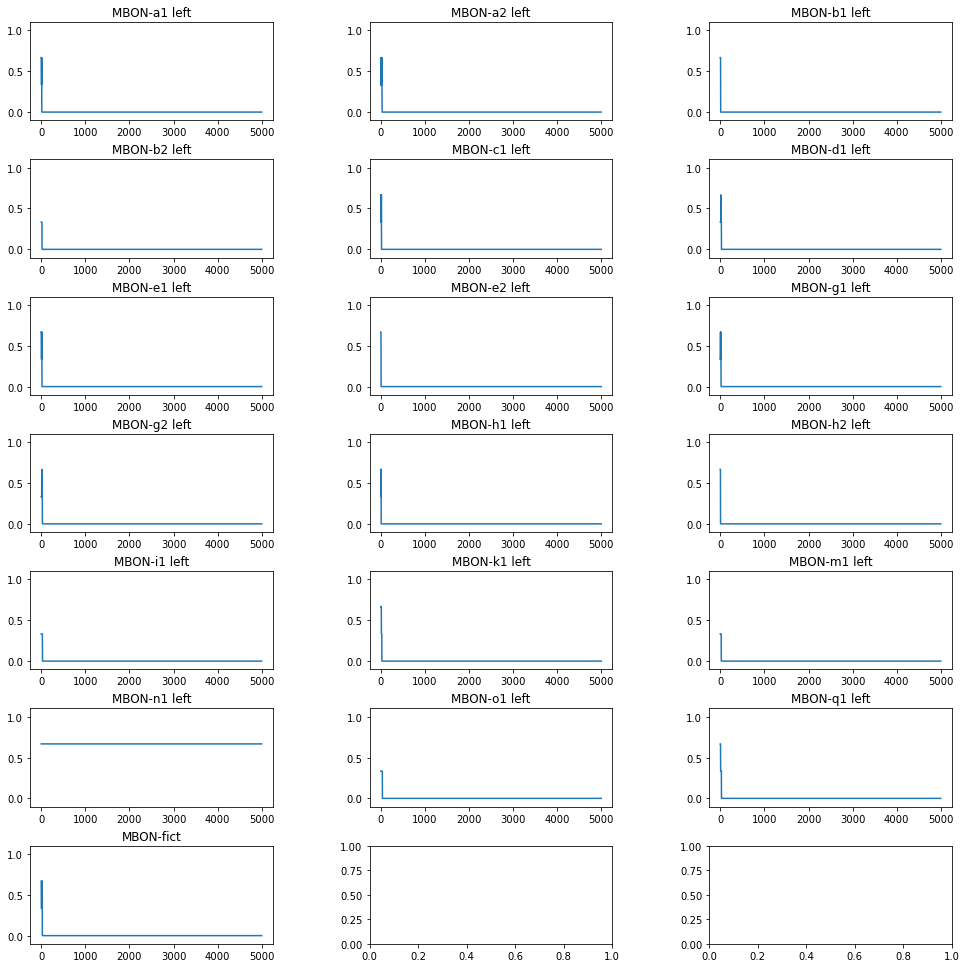

In [9]:
# neuron numbers
num_kcs = len(pn_kc.columns)
num_pns = len(pn_kc) # number of PNs (40), also = number of dimensions of the odor
num_mbons = len(kc_mbon.columns)

num_inputs = 15000 # num of input points
N = 3 # num of odors
T = 5000 # num of time points

# LOOP - RUN THRU MULTIPLE ROUNDS OF TRAINING W/ VARYING INPUT DISTS

R = 10 # number of runs of training 
eta = 0.01 # learning rate

all_error_rates = np.zeros((R, T, num_mbons)) # array to store error rates

all_kc_weights = np.zeros((R, num_kcs, num_mbons)) # array to store all final KC weights for each run
total_weights = np.zeros((R, T, num_kcs, num_mbons)) # array to store all KC weights over time for each realization

all_kc_biases = np.zeros((R, num_kcs)) # array to store KC biases from each run
all_mbon_biases = np.zeros((R, num_mbons)) # array to store MBON biases from each run

time = np.full((R, num_mbons), T+1) # records the time step where error rates for each MBON reached 0.05 or below

input_means = np.zeros((N, num_pns)) # records input distributions for input into network

all_kcs_removed = [[] for _ in range(R)] # stores the names of the KCs removed

# for rerunning with previous odors and removing based on previous weights
# with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v2/control/inputs1.pkl', 'rb') as f:
#     total_inputs = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v2/control/inputs-3D1.pkl', 'rb') as f:
#     total_inputs_3D = pickle.load(f) 

# with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v2/control/final-weights1.pkl', 'rb') as f:
#     prev_final_weights = pickle.load(f)

# GENERATING ODORS
# for running with new odors
spikes = 200
bool_response = np.random.binomial(1, 0.5, (N, num_pns))  # .5 probability - https://journals.physiology.org/doi/full/10.1152/jn.01283.2007   
probability = np.random.normal(0.8, 0.05, (N, num_pns)) # center, std, size
response = np.multiply(bool_response, probability)

# record input distributions
input_means = response

# # for running with same odors
# all_inputs = total_inputs
# pn_inputs = total_inputs_3D


# target outputs for each odor
odor_outputs = np.zeros((N, num_mbons))
# for i in range(N):
#     odor_outputs[i] = np.random.randint(0, 2, num_mbons)
# make sure output isn't the same for all odors for each PN
odor_outputs[0] = [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1]
odor_outputs[1] = [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0]
odor_outputs[2] = [1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0]
# odor_outputs[3] = [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0]
# odor_outputs[4] = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]
# odor_outputs[5] = [0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0]
# odor_outputs[6] = [0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1]
# odor_outputs[7] = [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
# odor_outputs[8] = [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0]
# odor_outputs[9] = [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0]

target_outputs = np.full((num_inputs, num_mbons), odor_outputs[0]) # array of target outputs used for training
for i in range(N):
    target_outputs[i*num_inputs//N:] = odor_outputs[i]

# LOOP THRU MULTIPLE RUNS OF TRAINING

for r in range(R):
    
    # generating input points
    all_inputs = np.zeros((num_inputs, num_pns)) # 2D input array used for neural network
    odor_idx = num_inputs//N
    pn_inputs = np.zeros((N, num_inputs//N, num_pns)) # 3D inputs separated by odor
    for n in range(N):
        inputs = np.random.binomial(spikes, response[n], size=(num_inputs//N, num_pns))
        all_inputs[n*odor_idx:odor_idx*(n + 1)] = inputs
        pn_inputs[n] = inputs
        
    # plot input distributions
    if r == 0:
        plt.figure()
        for i in range(N):
            plt.plot(pn_inputs[i, :, 2], pn_inputs[i, :, -3], '.', alpha = 0.2)
        plt.xlim(-5, 200)
        plt.ylim(-5, 200)

        plt.show()
        
    # SET BIAS VALUES FOR KCS
    kc_biases = np.zeros((num_kcs,)) # stores biases for all KCs
    pn_synapses = pn_kc.to_numpy()

    for i in range(num_kcs):
        w = pn_synapses[:, i] # get weights column by column (where columns correspond to # of synapses to each KC)
        kc_biases[i] = set_kc_bias(all_inputs, w)
        
    total_output1 = build_pn_to_kc(all_inputs, pn_synapses, kc_biases) # calculate all outputs of KCs for all input points
    # dimensions: inputs (15000 x 40), weights (40 x 110), biases (1 x 110) -> output (15000 x 110)
    
    # WEIGHTS
    kc_mbon_copy = kc_mbon.copy(deep=True) # weights (synapse table)
#     print(kc_mbon_copy)
    
    # REMOVE KCS WITH HIGH SYNAPTIC WEIGHT VALUES
#     weights, kc_names = ablate_top_kcs(prev_final_weights, kc_mbon_copy, 30, r) 
#     all_kcs_removed[r] = kc_names # record which KCs get ablated
#     weights = normalize_weights_np(weights, 1)

    # RANDOMLY ABLATE KCS
#     weights, kc_names = ablate_rand_kcs(kc_mbon_copy, 30)
#     all_kcs_removed[r] = kc_names # record which KCs' connections are randomly removed
#     weights = normalize_weights_np(weights, 1)
    
    # RANDOMLY PRUNE KCS
#     weights, kc_names = ablate_rand_kcs(kc_mbon_copy, 30)
#     all_kcs_removed[r] = kc_names # record which KCs' connections are randomly removed
#     weights = normalize_weights_np(weights, 1)

    # NOT REMOVING ANY WEIGHTS
    weights = kc_mbon_copy.to_numpy()
      
    # SET INITIAL VALUES
    bool_synapses = np.where(weights > 0, 1, 0) # boolean representation of the synaptic weights where an element is 1 if w > 0
    
    biases = np.full((num_mbons,), 0.1) # initialize all biases of MBONS at 0.1

    total_error_rate = np.zeros((T, num_mbons)) # stores percentage of correct outputs for each MBON

    total_output1 = build_pn_to_kc(all_inputs, pn_synapses, kc_biases) # calculate all outputs of KCs for all input points
    # dimensions: inputs (15000 x 40), weights (40 x 110), biases (1 x 110) -> output (15000 x 110)
    
    # LOOP THROUGH INPUTS TO TRAIN MODEL
    for p in range(T):

        # PN -> KC (fixed weights, biases)

        # get random index of input
        index = random.randint(num_inputs)

        # using input to PN layer, get output of KC layer
        output1 = total_output1[index]

        # KC -> MBON (training portion - weights, biases are updated)
        inputs = output1 # inputs taken from output of pn->kc
        output2 = build_kc_to_mbon(inputs, weights, biases)

        # CALCULATE TOTAL ERROR FOR ALL INPUTS
        total_output2 = build_kc_to_mbon(total_output1, weights, biases) # calculate total output of MBONs
        # dimensions: inputs (15000 x 110), weights (110 x 19), biases (1 x 19) -> output (15000 x 19)

        # NOTE: each column of output array represents output of each single MBON for all the inputs
        total_error = target_outputs - total_output2
        # dimensions: target output (15000 x 19), total output MBON (15000 x 19) -> error (15000 x 19)

        total_error_rate[p, :] = 1 - np.sum((total_error == 0), axis=0) / num_inputs # store current error rates
        
        # record when error rate for each MBON reaches a threshold (0.05 or less)
        current_error_rate = total_error_rate[p, :] # gets current error rates for all MBONS
        met_idxs = np.asarray(np.where(current_error_rate <= 0.05)).flatten() # indicies where the error rate meets 0.05 or less
        if len(met_idxs) > 0:
            for i in range(len(met_idxs)):
                idx = met_idxs[i]
                current = time[r, idx]
                if (current == T+1): # only if time step is not already recorded 
                    time[r, idx] = p # record the time step where target error rate was achieved

        # UPDATE VALUES
        error = target_outputs[index] - output2
        
        # record weights for this training step
        total_weights[r, p] = weights
        
        # update weights w/ the delta rule
        deltaw = np.outer(inputs, error) * eta # computes change in weights
        deltaw = np.multiply(deltaw, bool_synapses) # change only existing connections
        weights = weights + deltaw
        weights = normalize_weights_np(weights, 1) # normalize weights

        # update bias w/ the delta rule
        delta_bias = np.multiply(biases, error) * eta # computes change in biases
        biases = biases + delta_bias
    
    print("Realization {}: DONE".format(r+1))
    # PLOT ERROR RATES OVER TIME FOR EACH MBON
    figure, axis = plt.subplots(7, 3, figsize=(16, 16))

    a = 0
    for n in range(6):
        for m in range(3): 
            axis[n, m].plot(total_error_rate[:,a])
            axis[n, m].set_title(kc_mbon.columns[a])
            axis[n, m].set_ylim(-0.1, 1.1)
            a += 1

    axis[6, 0].plot(total_error_rate[:,18])
    axis[6, 0].set_title(kc_mbon.columns[18])
    axis[6, 0].set_ylim(-0.1, 1.1)

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    plt.show()

    # STORE FINAL VALUES
    all_error_rates[r] = total_error_rate # add error rate over time for this run to array that holds all error rates 
    all_kc_weights[r] = weights # add final weight for this run to array of all final weights
    
    all_kc_biases[r] = kc_biases # stores KC biases for each run
    all_mbon_biases[r] = biases # stores final MBON biases for each run

# AVERAGING ERROR RATES ACROSS RUNS
avg_error_rates = np.mean(all_error_rates, axis=0)


In [10]:
# SAVE DATA
# save final set of weights for each run
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/control2/total-weights7.pkl', 'wb') as f:
    pickle.dump(total_weights, f)
    
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/control2/final-weights7.pkl', 'wb') as f:
    pickle.dump(all_kc_weights, f)

# save final set of KC biases for each run
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/control2/final-kc-biases7.pkl', 'wb') as f:
    pickle.dump(all_kc_biases, f)

# save final set of MBON biases for each run
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/control2/final-mbon-biases7.pkl', 'wb') as f:
    pickle.dump(all_mbon_biases, f)

# save error rates over time
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/control2/all-error-rates7.pkl', 'wb') as f:
    pickle.dump(all_error_rates, f)
    
# save time for each MBON to learn
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/control2/target-met-time7.pkl', 'wb') as f:
    pickle.dump(time, f)
    
# save odor means
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/control2/input-means7.pkl', 'wb') as f:
    pickle.dump(input_means, f)
    
# # save input distributions
# with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v2/control/inputs1.pkl', 'wb') as f:
#     pickle.dump(total_inputs, f)
    
# with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v2/control/inputs-3D1.pkl', 'wb') as f:
#     pickle.dump(total_inputs_3D, f)
    
# save the names of KCs that were removed
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/control2/kcs-removed7.pkl', 'wb') as f:
    pickle.dump(all_kcs_removed, f)

<IPython.core.display.Javascript object>


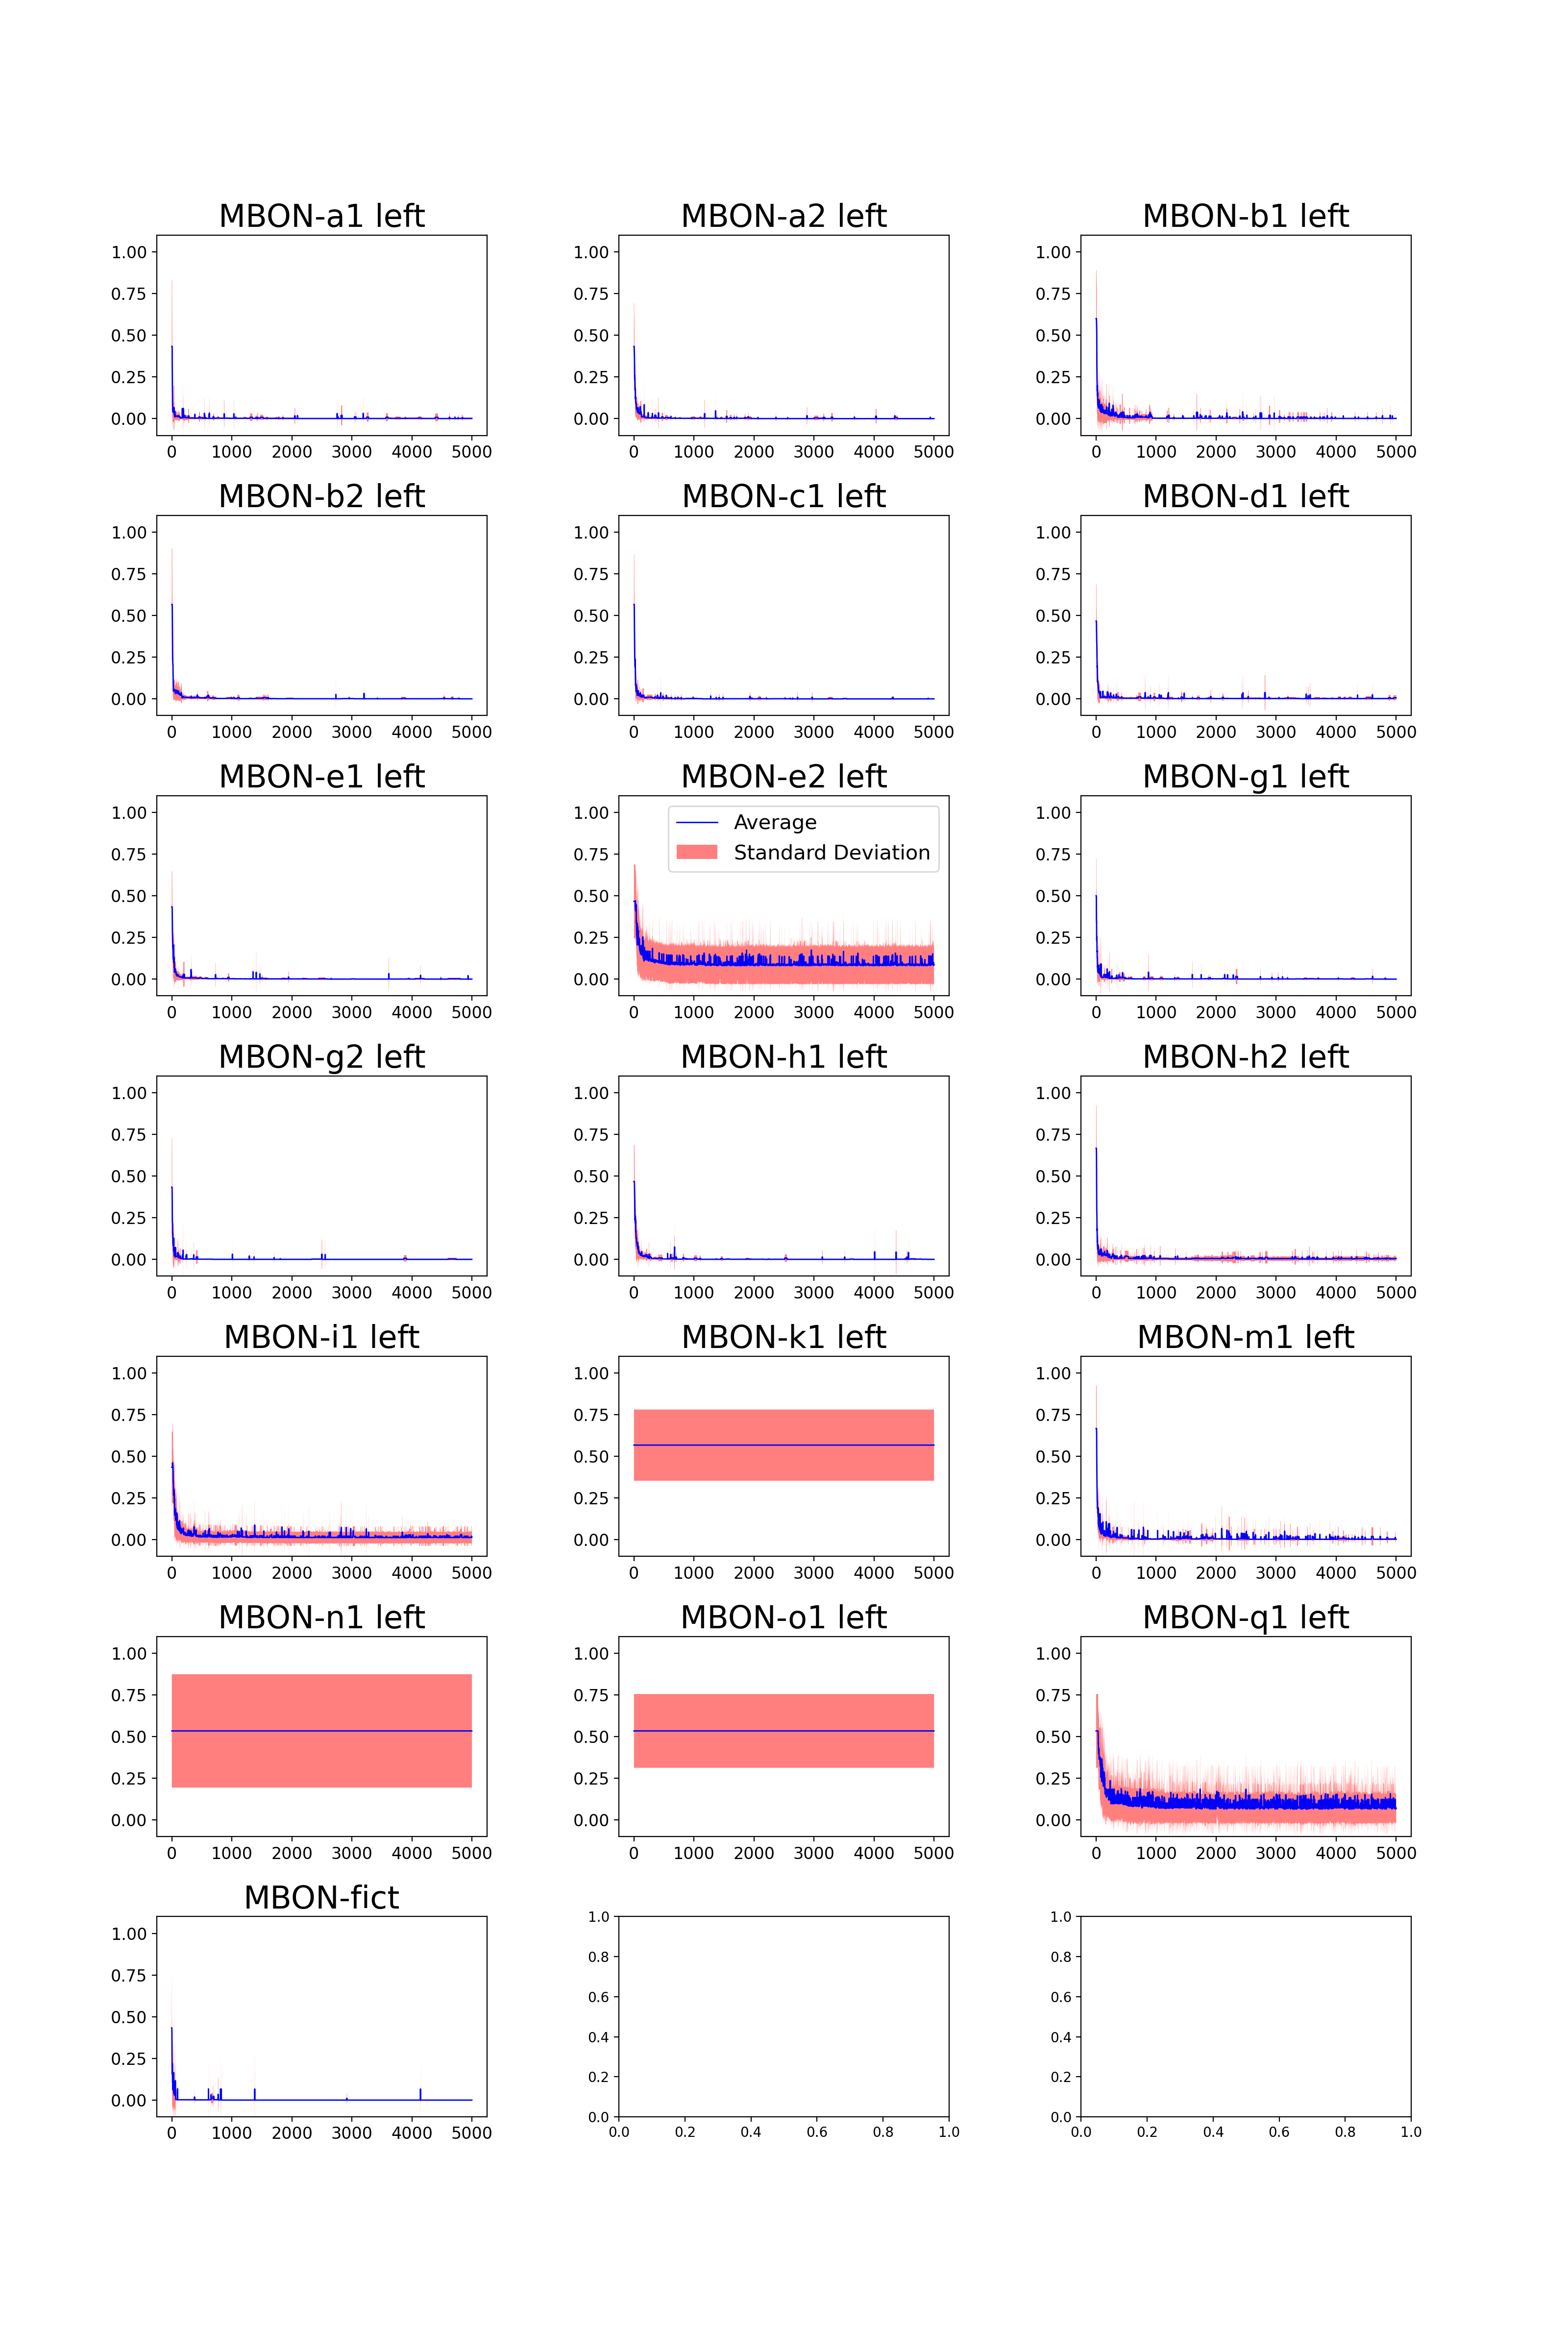

In [214]:
with open('C:/Users/Katherine Xie/RiseProject//all-error-rates23.pkl', 'rb') as f:
    error_rate_over_time = pickle.load(f)

avg_error = np.mean(error_rate_over_time, axis=0)

std_error = np.std(error_rate_over_time, axis=0)

x = np.linspace(0, 5000, 5000)
    
# PLOT AVERAGE ERROR RATES OVER TIME
figure, axis = plt.subplots(7, 3, figsize=(16, 24))

a = 0 
for n in range(7):
    for m in range(3):
        if a < 19:
            axis[n, m].set_title(kc_mbon.columns[a], fontsize=23)
            axis[n, m].set_ylim(-0.1, 1.1)

    #         for p in range(10):
    #             axis[n, m].plot(error_rate_over_time[p,:,a], color='red', alpha=0.2) # plot error rate lines from all 10 runs

            axis[n, m].plot(avg_error[:,a], color='blue', linewidth=1, label='Average') # plots average error rate
            axis[n, m].fill_between(x, avg_error[:,a] - std_error[:,a], avg_error[:,a] + std_error[:,a], alpha=0.5, facecolor='red', label='Standard Deviation')
            axis[n, m].tick_params(axis='x', labelsize=12)
            axis[n, m].tick_params(axis='y', labelsize=12)
        
        a += 1
axis[2, 1].legend(fontsize=15)
        
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

<IPython.core.display.Javascript object>


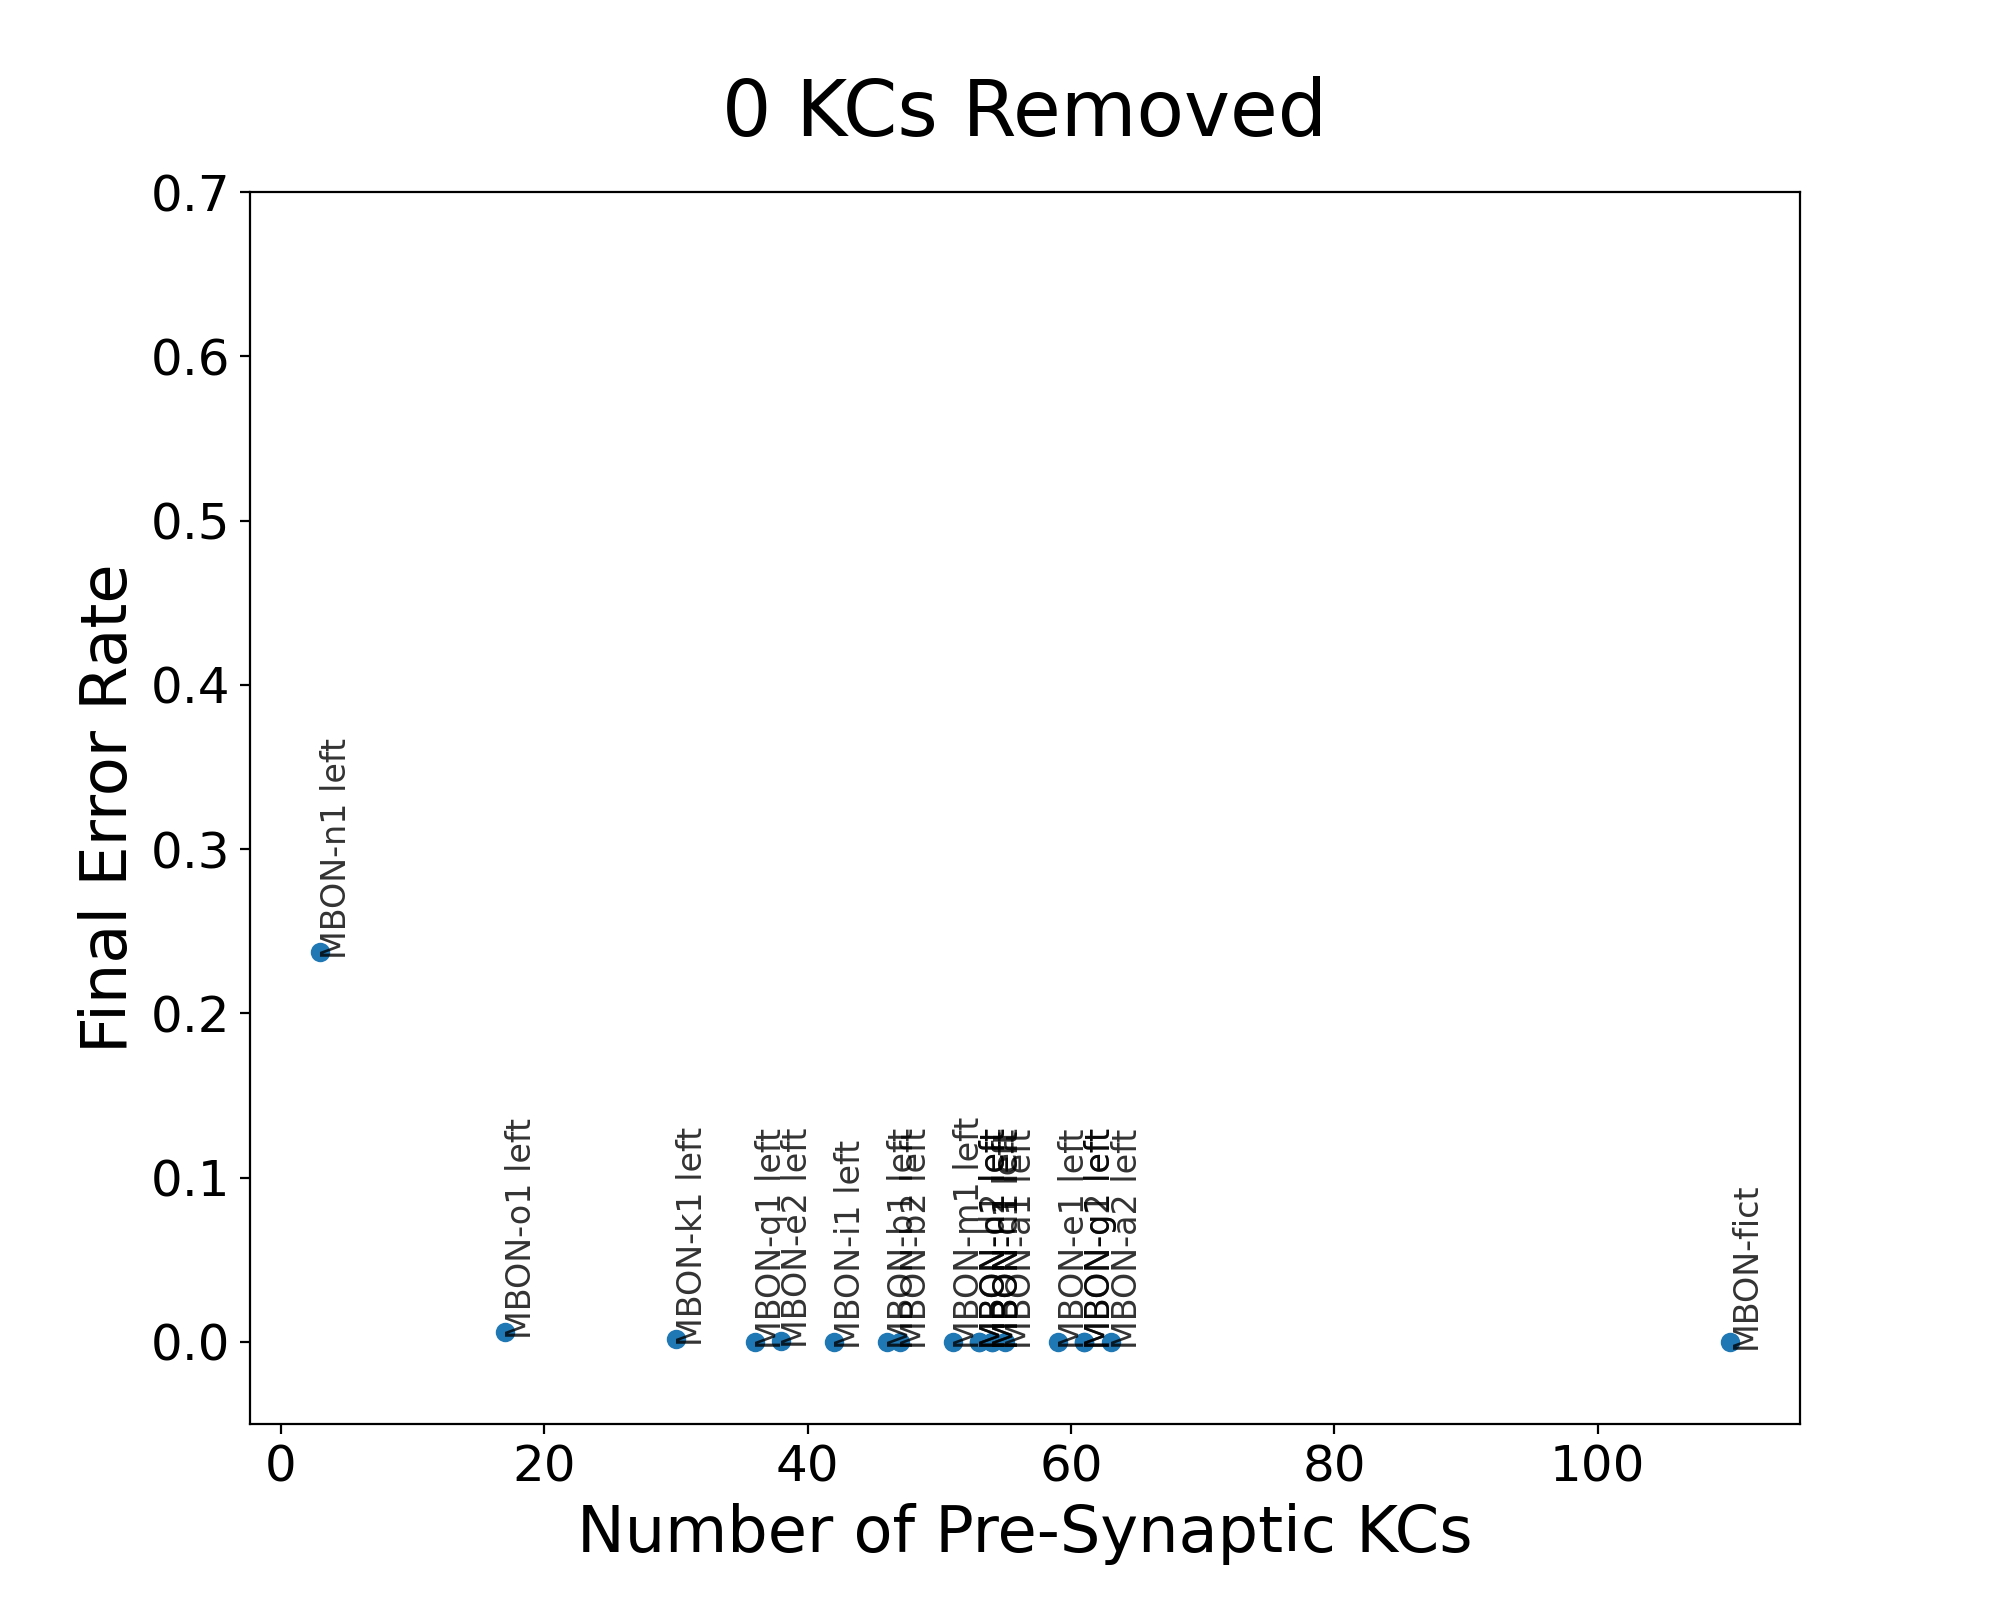

In [202]:
# PLOT NUMBER OF KC CONNECTIONS VS. AVG FINAL ERROR RATE

with open('C:/Users/Katherine Xie/RiseProject/run18-control-remove0KC-weightsum1/final-weights18.pkl', 'rb') as f:
    final_weights = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run18-control-remove0KC-weightsum1/all-error-rates18.pkl', 'rb') as f:
    error_rate_over_time = pickle.load(f)

N = 0 # number of KCs removed

avg_error = np.mean(error_rate_over_time, axis=0)

bool_conn = np.where(kc_mbon > 0, 1, 0)
sums = bool_conn.sum(axis=0)
# print(sums)
temp = np.where(sums - N < 0, 0, sums)
# print(temp)

plt.figure(figsize=(10,8))

x = np.subtract(temp, N, where=temp>0) # number of synapses
# print(x)
y = avg_error[-1,0:19] # final error rate

plt.plot(x, y, 'o')

# m, b = np.polyfit(x, y, 1)
# plt.plot(x, m*x + b, alpha=0.3)

# plt.title("Number of KC Connections vs. Average Final Error Rate (Ablate Top {} KCs)".format(N))
plt.title("0 KCs Removed", fontsize=28, pad=20)
plt.xlabel("Number of Pre-Synaptic KCs", fontsize=23)
plt.ylabel("Final Error Rate", fontsize=23)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.05, 0.7)

# label MBONs
names = kc_mbon.columns

for i, label in enumerate(names):
    plt.text(x[i], y[i], label, fontdict=dict(color='black', alpha=0.8, size=12, fontfamily='sans-serif'), rotation='vertical')


plt.show()

<IPython.core.display.Javascript object>


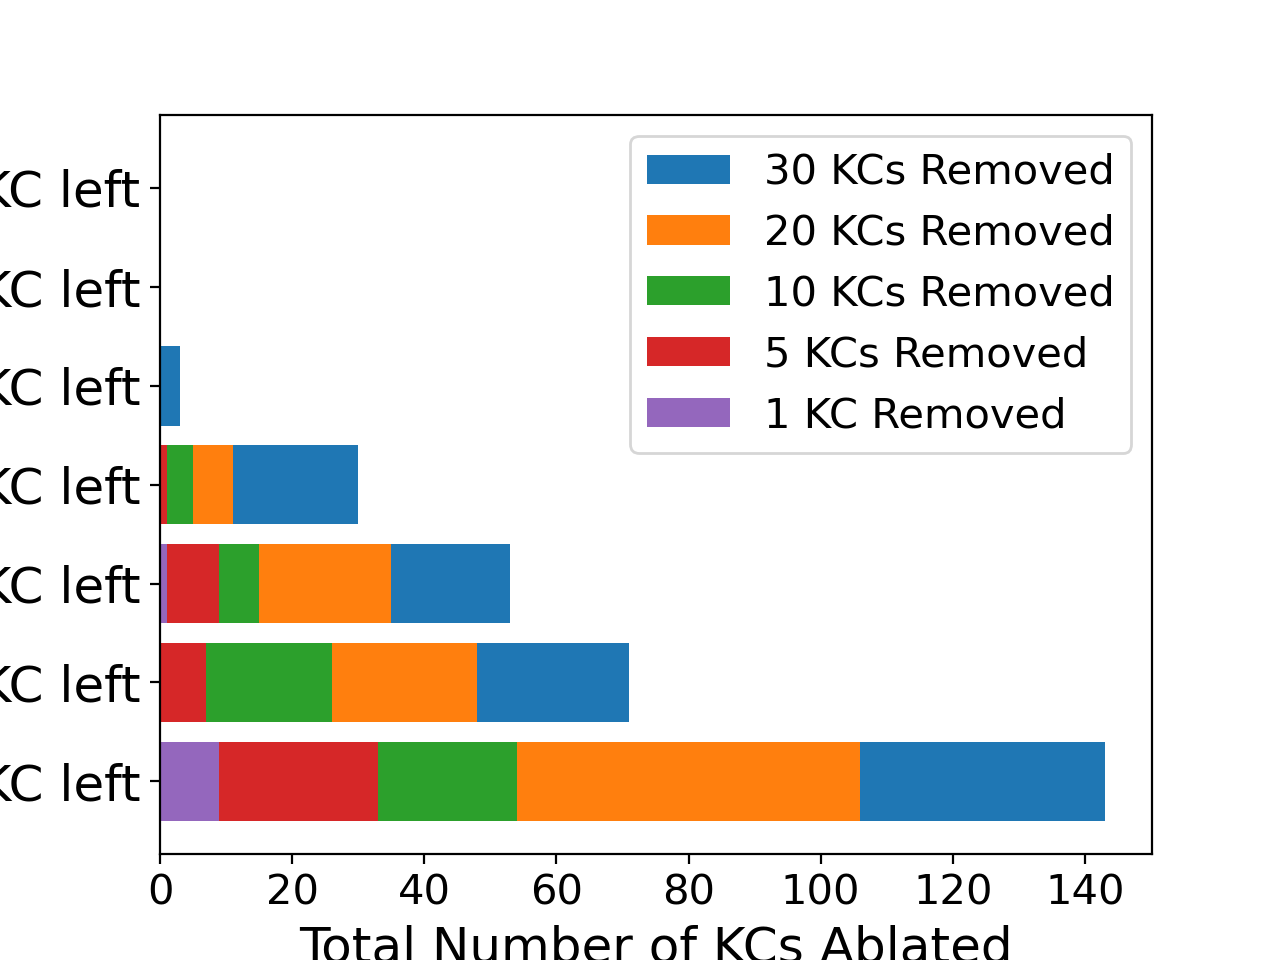

In [201]:
# counts number of occurrences of a string in a 2d list
def countX(lst, x):
    count = 0
    for i in range(len(lst)):
        for j in range(len(lst[i])):
            if (lst[i][j] == x):
                count = count + 1
    return count

# BAR GRAPH OF TYPE OF KC REMOVED (5 removed)
plt.figure()
names = ['1 claw KC left', '2 claw KC left', '3 claw KC left', '4 claw KC left', '5 claw KC left', '6 claw KC left', 'young KC left']

with open('C:/Users/Katherine Xie/RiseProject/run17-ablatetop30KC-weightsum1/kcs-removed17.pkl', 'rb') as f:
    kc_names = pickle.load(f)
    
counts = []
counts.append(countX(kc_names, '1 claw KC left'))
counts.append(countX(kc_names, '2 claw KC left'))
counts.append(countX(kc_names, '3 claw KC left'))
counts.append(countX(kc_names, '4 claw KC left'))
counts.append(countX(kc_names, '5 claw KC left'))
counts.append(countX(kc_names, '6 claw KC left'))
counts.append(countX(kc_names, 'young KC left'))

plt.barh(names, counts, label='30 KCs Removed')

with open('C:/Users/Katherine Xie/RiseProject/run16-ablatetop20KC-weightsum1/kcs-removed16.pkl', 'rb') as f:
    kc_names = pickle.load(f)
    
counts = []
counts.append(countX(kc_names, '1 claw KC left'))
counts.append(countX(kc_names, '2 claw KC left'))
counts.append(countX(kc_names, '3 claw KC left'))
counts.append(countX(kc_names, '4 claw KC left'))
counts.append(countX(kc_names, '5 claw KC left'))
counts.append(countX(kc_names, '6 claw KC left'))
counts.append(countX(kc_names, 'young KC left'))

plt.barh(names, counts, label='20 KCs Removed')

with open('C:/Users/Katherine Xie/RiseProject/run15-ablatetop10KC-weightsum1/kcs-removed15.pkl', 'rb') as f:
    kc_names = pickle.load(f)
    
counts = []
counts.append(countX(kc_names, '1 claw KC left'))
counts.append(countX(kc_names, '2 claw KC left'))
counts.append(countX(kc_names, '3 claw KC left'))
counts.append(countX(kc_names, '4 claw KC left'))
counts.append(countX(kc_names, '5 claw KC left'))
counts.append(countX(kc_names, '6 claw KC left'))
counts.append(countX(kc_names, 'young KC left'))

plt.barh(names, counts, label='10 KCs Removed')

with open('C:/Users/Katherine Xie/RiseProject/run14-ablatetop5KC-weightsum1/kcs-removed14.pkl', 'rb') as f:
    kc_names = pickle.load(f)
    
counts = []
counts.append(countX(kc_names, '1 claw KC left'))
counts.append(countX(kc_names, '2 claw KC left'))
counts.append(countX(kc_names, '3 claw KC left'))
counts.append(countX(kc_names, '4 claw KC left'))
counts.append(countX(kc_names, '5 claw KC left'))
counts.append(countX(kc_names, '6 claw KC left'))
counts.append(countX(kc_names, 'young KC left'))

plt.barh(names, counts, label='5 KCs Removed')

with open('C:/Users/Katherine Xie/RiseProject/run13-ablatetop1KC-weightsum1/kcs-removed13.pkl', 'rb') as f:
    kc_names = pickle.load(f)
    
counts = []
counts.append(countX(kc_names, '1 claw KC left'))
counts.append(countX(kc_names, '2 claw KC left'))
counts.append(countX(kc_names, '3 claw KC left'))
counts.append(countX(kc_names, '4 claw KC left'))
counts.append(countX(kc_names, '5 claw KC left'))
counts.append(countX(kc_names, '6 claw KC left'))
counts.append(countX(kc_names, 'young KC left'))

plt.barh(names, counts, label='1 KC Removed')

plt.xlabel("Total Number of KCs Ablated", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=18, rotation=0)

plt.legend(fontsize=15)
plt.show()

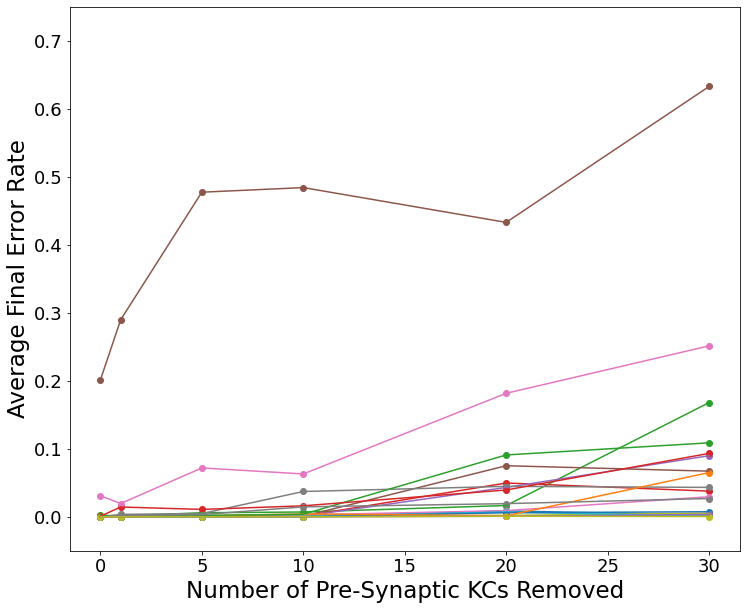

In [176]:
# NUMBER OF KCS REMOVED VS. FINAL ERROR RATE - TARGETED ABLATION OF TOP KCS

# import data
# 0 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run36-r0-w1-sameodorsrun12/final-weights36.pkl', 'rb') as f:
    final_weights0 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run36-r0-w1-sameodorsrun12/all-error-rates36.pkl', 'rb') as f:
    error_over_time0 = pickle.load(f)
# 1 KC removed
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run37-top1-w1-odor3/final-weights37.pkl', 'rb') as f:
    final_weights1 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run37-top1-w1-odor3/all-error-rates37.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f)
# 5 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run38-top5-w1-odor3/final-weights38.pkl', 'rb') as f:
    final_weights5 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run38-top5-w1-odor3/all-error-rates38.pkl', 'rb') as f:
    error_over_time5 = pickle.load(f)
# 10 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run39-top10-w1-odor3/final-weights39.pkl', 'rb') as f:
    final_weights10 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run39-top10-w1-odor3/all-error-rates39.pkl', 'rb') as f:
    error_over_time10 = pickle.load(f)
# 20 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run40-top20-w1-odor3/final-weights40.pkl', 'rb') as f:
    final_weights20 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run40-top20-w1-odor3/all-error-rates40.pkl', 'rb') as f:
    error_over_time20 = pickle.load(f)
# 30 KCs removed    
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run41-top30-w1-odor3/final-weights41.pkl', 'rb') as f:
    final_weights30 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run41-top30-w1-odor3/all-error-rates41.pkl', 'rb') as f:
    error_over_time30 = pickle.load(f)
     
plt.figure(figsize=(12, 10))
# x-axis -> number of KCs removed
numbers = [0, 1, 5, 10, 20, 30] # numbers of KCs removed
x = []
        
for i in range(num_mbons):
    for j in range(6):
        x.append(numbers[j])

# y-axis - avg final error rate
avg_error0 = np.mean(error_over_time0, axis=0)
avg_error1 = np.mean(error_over_time1, axis=0)
avg_error5 = np.mean(error_over_time5, axis=0)
avg_error10 = np.mean(error_over_time10, axis=0)
avg_error20 = np.mean(error_over_time20, axis=0)
avg_error30 = np.mean(error_over_time30, axis=0)

y = []
# add each MBONs' error rates for different number of KCs removed
for k in range(num_mbons):
    y.append(avg_error0[-1,k])
    y.append(avg_error1[-1,k])
    y.append(avg_error5[-1,k])
    y.append(avg_error10[-1,k])
    y.append(avg_error20[-1,k])
    y.append(avg_error30[-1,k])

# plot points with lines
for p in range(num_mbons):
    start = p * 6
    end = (p * 6) + 6
    plt.scatter(x[start:end], y[start:end])
    plt.plot(x[start:end], y[start:end])

plt.xlabel("Number of Pre-Synaptic KCs Removed", fontsize=23)
plt.ylabel("Average Final Error Rate", fontsize=23)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.05, 0.75)
plt.show()

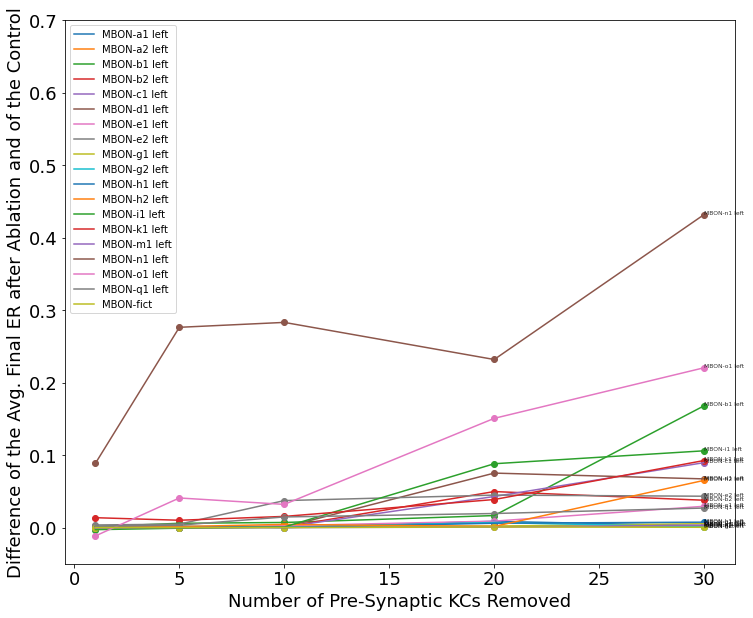

In [175]:
# NUMBER OF KCS REMOVED VS. FINAL ERROR RATE MINUS CONTROL ERROR RATE - TARGETED ABLATION OF TOP KCS

# import data
# 0 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run36-r0-w1-sameodorsrun12/final-weights36.pkl', 'rb') as f:
    final_weights0 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run36-r0-w1-sameodorsrun12/all-error-rates36.pkl', 'rb') as f:
    error_over_time0 = pickle.load(f)
# 1 KC removed
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run37-top1-w1-odor3/final-weights37.pkl', 'rb') as f:
    final_weights1 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run37-top1-w1-odor3/all-error-rates37.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f)
# 5 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run38-top5-w1-odor3/final-weights38.pkl', 'rb') as f:
    final_weights5 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run38-top5-w1-odor3/all-error-rates38.pkl', 'rb') as f:
    error_over_time5 = pickle.load(f)
# 10 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run39-top10-w1-odor3/final-weights39.pkl', 'rb') as f:
    final_weights10 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run39-top10-w1-odor3/all-error-rates39.pkl', 'rb') as f:
    error_over_time10 = pickle.load(f)
# 20 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run40-top20-w1-odor3/final-weights40.pkl', 'rb') as f:
    final_weights20 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run40-top20-w1-odor3/all-error-rates40.pkl', 'rb') as f:
    error_over_time20 = pickle.load(f)
# 30 KCs removed    
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run41-top30-w1-odor3/final-weights41.pkl', 'rb') as f:
    final_weights30 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run41-top30-w1-odor3/all-error-rates41.pkl', 'rb') as f:
    error_over_time30 = pickle.load(f)
    
plt.figure(figsize=(12, 10))
# x-axis -> number of KCs removed
numbers = [1, 5, 10, 20, 30] # numbers of KCs removed
x = []
        
for i in range(num_mbons):
    for j in range(5):
        x.append(numbers[j])

# y-axis - avg final error rate
avg_error0 = np.mean(error_over_time0, axis=0)
avg_error1 = np.mean(error_over_time1, axis=0)
avg_error5 = np.mean(error_over_time5, axis=0)
avg_error10 = np.mean(error_over_time10, axis=0)
avg_error20 = np.mean(error_over_time20, axis=0)
avg_error30 = np.mean(error_over_time30, axis=0)

y = []
# add differences in ablation error rate and control
for k in range(num_mbons):
    y.append(avg_error1[-1,k] - avg_error0[-1,k])
    y.append(avg_error5[-1,k] - avg_error0[-1,k])
    y.append(avg_error10[-1,k] - avg_error0[-1,k])
    y.append(avg_error20[-1,k] - avg_error0[-1,k])
    y.append(avg_error30[-1,k] - avg_error0[-1,k])

# plot points with lines and labels
names = kc_mbon.columns
for p in range(num_mbons):
    start = p * 5
    end = (p * 5) + 5
    plt.scatter(x[start:end], y[start:end])
    plt.plot(x[start:end], y[start:end], label=kc_mbon.columns[p])
    plt.text(30, y[end-1], names[p], fontdict=dict(color='black', alpha=0.8, size=6, fontfamily='sans-serif'))

plt.xlabel("Number of Pre-Synaptic KCs Removed", fontsize=18)
plt.ylabel("Difference of the Avg. Final ER after Ablation and of the Control", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.05, 0.7)
plt.legend()
plt.show()

In [216]:
# standard errors in error rate of poor performing MBONs
print("MBON-o1 left")
print(st.sem(error_over_time30[:,-1,16]))

print("MBON-k1 left")
print(st.sem(error_over_time30[:,-1,13]))

MBON-o1 left
0.06344830126436272
MBON-k1 left
0.041083323281495276


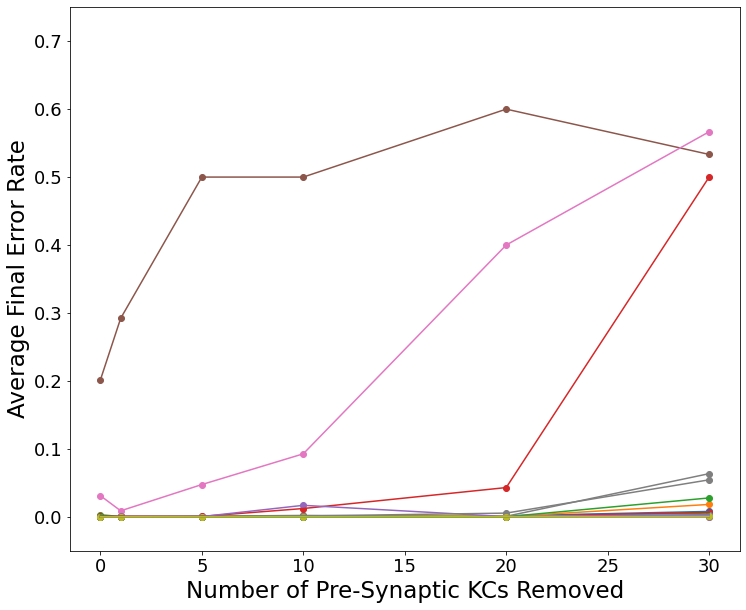

In [179]:
# NUMBER OF KCS REMOVED VS. FINAL ERROR RATE - RANDOM ABLATION

# import data
# 0 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run36-r0-w1-sameodorsrun12/final-weights36.pkl', 'rb') as f:
    final_weights0 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run36-r0-w1-sameodorsrun12/all-error-rates36.pkl', 'rb') as f:
    error_over_time0 = pickle.load(f)
# 1 KC removed
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run42-rand1-w1-odor3/final-weights42.pkl', 'rb') as f:
    final_weights1 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run42-rand1-w1-odor3/all-error-rates42.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f)
# 5 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run43-rand5-w1-odor3/final-weights43.pkl', 'rb') as f:
    final_weights5 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run43-rand5-w1-odor3/all-error-rates43.pkl', 'rb') as f:
    error_over_time5 = pickle.load(f)
# 10 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run44-rand10-w1-odor3/final-weights44.pkl', 'rb') as f:
    final_weights10 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run44-rand10-w1-odor3/all-error-rates44.pkl', 'rb') as f:
    error_over_time10 = pickle.load(f)
# 20 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run45-rand20-w1-odor3/final-weights45.pkl', 'rb') as f:
    final_weights20 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run45-rand20-w1-odor3/all-error-rates45.pkl', 'rb') as f:
    error_over_time20 = pickle.load(f)
# 30 KCs removed    
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run46-rand30-w1-odor3/final-weights46.pkl', 'rb') as f:
    final_weights30 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run46-rand30-w1-odor3/all-error-rates46.pkl', 'rb') as f:
    error_over_time30 = pickle.load(f)
     
plt.figure(figsize=(12, 10))
# x-axis -> number of KCs removed
numbers = [0, 1, 5, 10, 20, 30] # numbers of KCs removed
x = []
        
for i in range(num_mbons):
    for j in range(6):
        x.append(numbers[j])

# y-axis - avg final error rate
avg_error0 = np.mean(error_over_time0, axis=0)
avg_error1 = np.mean(error_over_time1, axis=0)
avg_error5 = np.mean(error_over_time5, axis=0)
avg_error10 = np.mean(error_over_time10, axis=0)
avg_error20 = np.mean(error_over_time20, axis=0)
avg_error30 = np.mean(error_over_time30, axis=0)

y = []
# add error rates for each MBON
for k in range(num_mbons):
    y.append(avg_error0[-1,k])
    y.append(avg_error1[-1,k])
    y.append(avg_error5[-1,k])
    y.append(avg_error10[-1,k])
    y.append(avg_error20[-1,k])
    y.append(avg_error30[-1,k])

# plot with points and lines
for p in range(num_mbons):
    start = p * 6
    end = (p * 6) + 6
    plt.scatter(x[start:end], y[start:end])
    plt.plot(x[start:end], y[start:end])

plt.xlabel("Number of Pre-Synaptic KCs Removed", fontsize=23)
plt.ylabel("Average Final Error Rate", fontsize=23)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.05, 0.75)
plt.show()

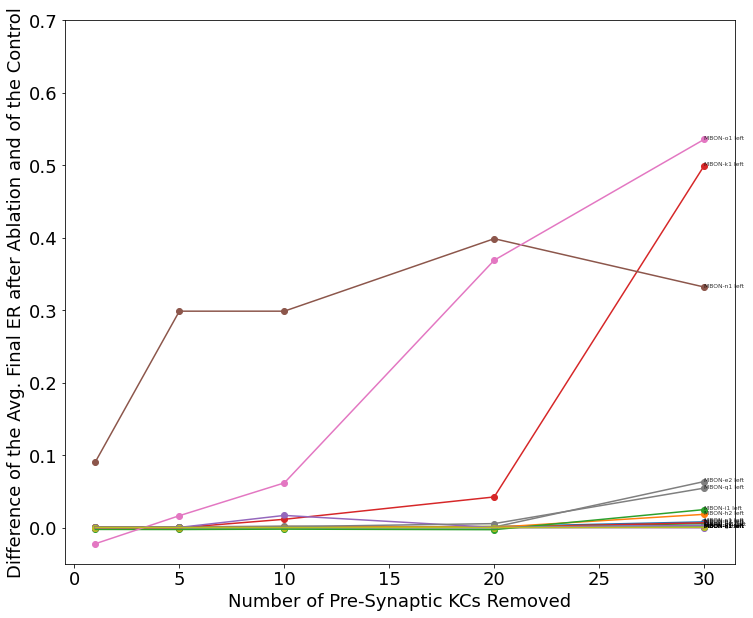

In [180]:
# NUMBER OF KCS REMOVED VS. FINAL ERROR RATE MINUS CONTROL ERROR RATE - RANDOM ABLATION

# import data
# 0 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run36-r0-w1-sameodorsrun12/final-weights36.pkl', 'rb') as f:
    final_weights0 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run36-r0-w1-sameodorsrun12/all-error-rates36.pkl', 'rb') as f:
    error_over_time0 = pickle.load(f)
# 1 KC removed
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run42-rand1-w1-odor3/final-weights42.pkl', 'rb') as f:
    final_weights1 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run42-rand1-w1-odor3/all-error-rates42.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f)
# 5 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run43-rand5-w1-odor3/final-weights43.pkl', 'rb') as f:
    final_weights5 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run43-rand5-w1-odor3/all-error-rates43.pkl', 'rb') as f:
    error_over_time5 = pickle.load(f)
# 10 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run44-rand10-w1-odor3/final-weights44.pkl', 'rb') as f:
    final_weights10 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run44-rand10-w1-odor3/all-error-rates44.pkl', 'rb') as f:
    error_over_time10 = pickle.load(f)
# 20 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run45-rand20-w1-odor3/final-weights45.pkl', 'rb') as f:
    final_weights20 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run45-rand20-w1-odor3/all-error-rates45.pkl', 'rb') as f:
    error_over_time20 = pickle.load(f)
# 30 KCs removed    
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run46-rand30-w1-odor3/final-weights46.pkl', 'rb') as f:
    final_weights30 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run46-rand30-w1-odor3/all-error-rates46.pkl', 'rb') as f:
    error_over_time30 = pickle.load(f)
     
plt.figure(figsize=(12, 10))
# x-axis -> number of KCs removed
numbers = [1, 5, 10, 20, 30] # numbers of KCs removed
x = []
        
for i in range(num_mbons):
    for j in range(5):
        x.append(numbers[j])

# y-axis - avg final error rate
avg_error0 = np.mean(error_over_time0, axis=0)
avg_error1 = np.mean(error_over_time1, axis=0)
avg_error5 = np.mean(error_over_time5, axis=0)
avg_error10 = np.mean(error_over_time10, axis=0)
avg_error20 = np.mean(error_over_time20, axis=0)
avg_error30 = np.mean(error_over_time30, axis=0)

y = []
# add differences in error rates and control error rate to y
for k in range(num_mbons):
    y.append(avg_error1[-1,k] - avg_error0[-1,k])
    y.append(avg_error5[-1,k] - avg_error0[-1,k])
    y.append(avg_error10[-1,k] - avg_error0[-1,k])
    y.append(avg_error20[-1,k] - avg_error0[-1,k])
    y.append(avg_error30[-1,k] - avg_error0[-1,k])

# plot with points and lines
for p in range(num_mbons):
    start = p * 5
    end = (p * 5) + 5
    plt.scatter(x[start:end], y[start:end])
    plt.plot(x[start:end], y[start:end])
    plt.text(30, y[end-1], names[p], fontdict=dict(color='black', alpha=0.8, size=6, fontfamily='sans-serif'))

plt.xlabel("Number of Pre-Synaptic KCs Removed", fontsize=18)
plt.ylabel("Difference of the Avg. Final ER after Ablation and of the Control", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.05, 0.7)
plt.show()

In [218]:
# standard errors in error rate of poor performing MBONs
print("MBON-o1 left")
print(st.sem(error_over_time30[:,-1,16]))

print("MBON-k1 left")
print(st.sem(error_over_time30[:,-1,13]))

MBON-o1 left
0.0737027731190089
MBON-k1 left
0.07114582486036498


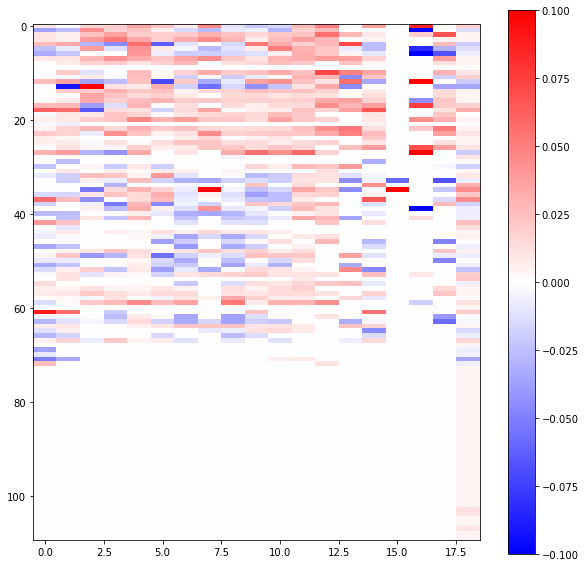

In [118]:
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run37-top1-w1-odor3/final-weights37.pkl', 'rb') as f:
    final_weights = pickle.load(f)
    
# HEATMAP OF WEIGHTS SUM 2 
plt.figure(figsize=(10,10))
c1 = plt.imshow(final_weights[0], cmap="bwr", clim=(-.1,.1), aspect=.2)
plt.colorbar(c1)
plt.show()

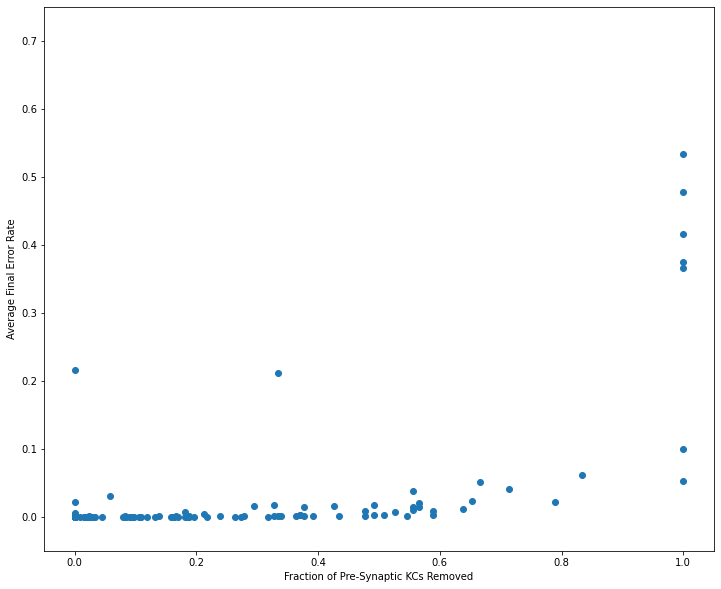

In [117]:
# FRACTION OF KCS REMOVED VS. FINAL ERROR RATE - TARGETED ABLATION OF TOP KCS

# import data
# 0 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run18-control-remove0KC-weightsum2/final-weights18.pkl', 'rb') as f:
    final_weights0 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run18-control-remove0KC-weightsum2/all-error-rates18.pkl', 'rb') as f:
    error_over_time0 = pickle.load(f)
# 1 KC removed
with open('C:/Users/Katherine Xie/RiseProject/run13-ablatetop1KC-weightsum2/final-weights13.pkl', 'rb') as f:
    final_weights1 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run13-ablatetop1KC-weightsum2/all-error-rates13.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f)
# 5 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run14-ablatetop5KC-weightsum2/final-weights14.pkl', 'rb') as f:
    final_weights5 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run14-ablatetop5KC-weightsum2/all-error-rates14.pkl', 'rb') as f:
    error_over_time5 = pickle.load(f)
# 10 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run15-ablatetop10KC-weightsum2/final-weights15.pkl', 'rb') as f:
    final_weights10 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run15-ablatetop10KC-weightsum2/all-error-rates15.pkl', 'rb') as f:
    error_over_time10 = pickle.load(f)
# 20 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run16-ablatetop20KC-weightsum2/final-weights16.pkl', 'rb') as f:
    final_weights20 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run16-ablatetop20KC-weightsum2/all-error-rates16.pkl', 'rb') as f:
    error_over_time20 = pickle.load(f)
# 30 KCs removed    
with open('C:/Users/Katherine Xie/RiseProject/run17-ablatetop30KC-weightsum2/final-weights17.pkl', 'rb') as f:
    final_weights30 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run17-ablatetop30KC-weightsum2/all-error-rates17.pkl', 'rb') as f:
    error_over_time30 = pickle.load(f)
     
plt.figure(figsize=(12, 10))
# x-axis -> number of KCs removed
numbers = [0, 1, 5, 10, 20, 30] # numbers of KCs removed
x = []
for i in range(6):
    for j in range(num_mbons):
        x.append(numbers[i]) 

# print(x)      
# calculate fraction of kcs removed
bool_conn = np.where(kc_mbon > 0, 1, 0)
num_pre_kcs = bool_conn.sum(axis=0) # number of KCs originally

for i in range(6):
    start = i * num_mbons
    end = start + num_mbons
    arr = x[start:end]
    x[start:end] = np.divide(arr, num_pre_kcs)

x = np.array(x)
x = np.where(x > 1, 1, x)

# y-axis - avg final error rate
avg_error0 = np.mean(error_over_time0, axis=0)
avg_error1 = np.mean(error_over_time1, axis=0)
avg_error5 = np.mean(error_over_time5, axis=0)
avg_error10 = np.mean(error_over_time10, axis=0)
avg_error20 = np.mean(error_over_time20, axis=0)
avg_error30 = np.mean(error_over_time30, axis=0)

y = []
# add error rates for each number of KCs removed across all MBONS to y
y.extend(avg_error0[-1,0:19])
y.extend(avg_error1[-1,0:19])
y.extend(avg_error5[-1,0:19])
y.extend(avg_error10[-1,0:19])
y.extend(avg_error20[-1,0:19])
y.extend(avg_error30[-1,0:19])

plt.plot(x, y, 'o')

plt.xlabel("Fraction of Pre-Synaptic KCs Removed")
plt.ylabel("Average Final Error Rate")
plt.ylim(-0.05, 0.75)
plt.show()

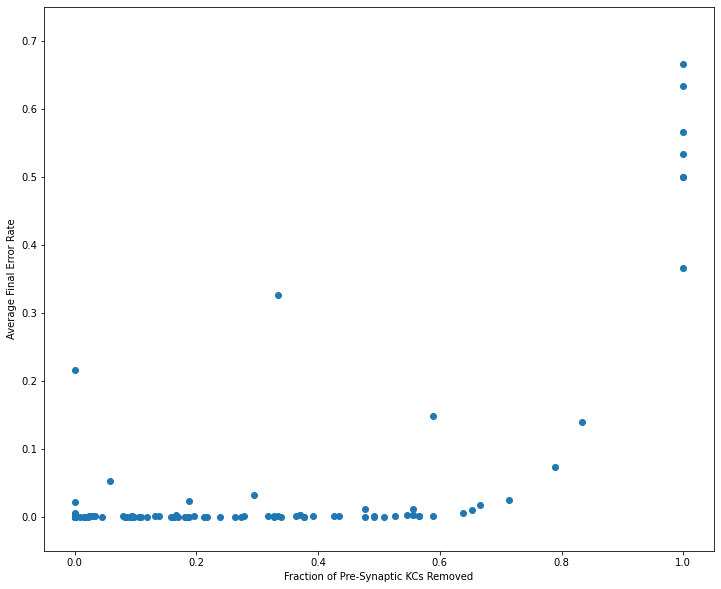

In [118]:
# FRACTION OF KCS REMOVED VS. FINAL ERROR RATE - TARGETED ABLATION OF TOP KCS

# import data
# 0 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run18-control-remove0KC-weightsum2/final-weights18.pkl', 'rb') as f:
    final_weights0 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run18-control-remove0KC-weightsum2/all-error-rates18.pkl', 'rb') as f:
    error_over_time0 = pickle.load(f)
# 1 KC removed
with open('C:/Users/Katherine Xie/RiseProject/run19-randremove1KC-weightsum2/final-weights19.pkl', 'rb') as f:
    final_weights1 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run19-randremove1KC-weightsum2/all-error-rates19.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f)
# 5 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run20-randremove5KC-weightsum2/final-weights20.pkl', 'rb') as f:
    final_weights5 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run20-randremove5KC-weightsum2/all-error-rates20.pkl', 'rb') as f:
    error_over_time5 = pickle.load(f)
# 10 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run21-randremove10KC-weightsum2/final-weights21.pkl', 'rb') as f:
    final_weights10 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run21-randremove10KC-weightsum2/all-error-rates21.pkl', 'rb') as f:
    error_over_time10 = pickle.load(f)
# 20 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run22-randremove20KC-weightsum2/final-weights22.pkl', 'rb') as f:
    final_weights20 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run22-randremove20KC-weightsum2/all-error-rates22.pkl', 'rb') as f:
    error_over_time20 = pickle.load(f)
# 30 KCs removed    
with open('C:/Users/Katherine Xie/RiseProject/run23-randremove30KC-weightsum2/final-weights23.pkl', 'rb') as f:
    final_weights30 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run23-randremove30KC-weightsum2/all-error-rates23.pkl', 'rb') as f:
    error_over_time30 = pickle.load(f)
     
plt.figure(figsize=(12, 10))
# x-axis -> number of KCs removed
numbers = [0, 1, 5, 10, 20, 30] # numbers of KCs removed
x = []
for i in range(6):
    for j in range(num_mbons):
        x.append(numbers[i]) 

# print(x)      
# calculate fraction of kcs removed
bool_conn = np.where(kc_mbon > 0, 1, 0)
num_pre_kcs = bool_conn.sum(axis=0) # number of KCs originally

for i in range(6):
    start = i * num_mbons
    end = start + num_mbons
    arr = x[start:end]
    x[start:end] = np.divide(arr, num_pre_kcs)

x = np.array(x)
x = np.where(x > 1, 1, x)

# y-axis - avg final error rate
avg_error0 = np.mean(error_over_time0, axis=0)
avg_error1 = np.mean(error_over_time1, axis=0)
avg_error5 = np.mean(error_over_time5, axis=0)
avg_error10 = np.mean(error_over_time10, axis=0)
avg_error20 = np.mean(error_over_time20, axis=0)
avg_error30 = np.mean(error_over_time30, axis=0)

y = []
# add error rates for each number of KCs removed across all MBONS to y
y.extend(avg_error0[-1,0:19])
y.extend(avg_error1[-1,0:19])
y.extend(avg_error5[-1,0:19])
y.extend(avg_error10[-1,0:19])
y.extend(avg_error20[-1,0:19])
y.extend(avg_error30[-1,0:19])

plt.plot(x, y, 'o')

plt.xlabel("Fraction of Pre-Synaptic KCs Removed")
plt.ylabel("Average Final Error Rate")
plt.ylim(-0.05, 0.75)
plt.show()

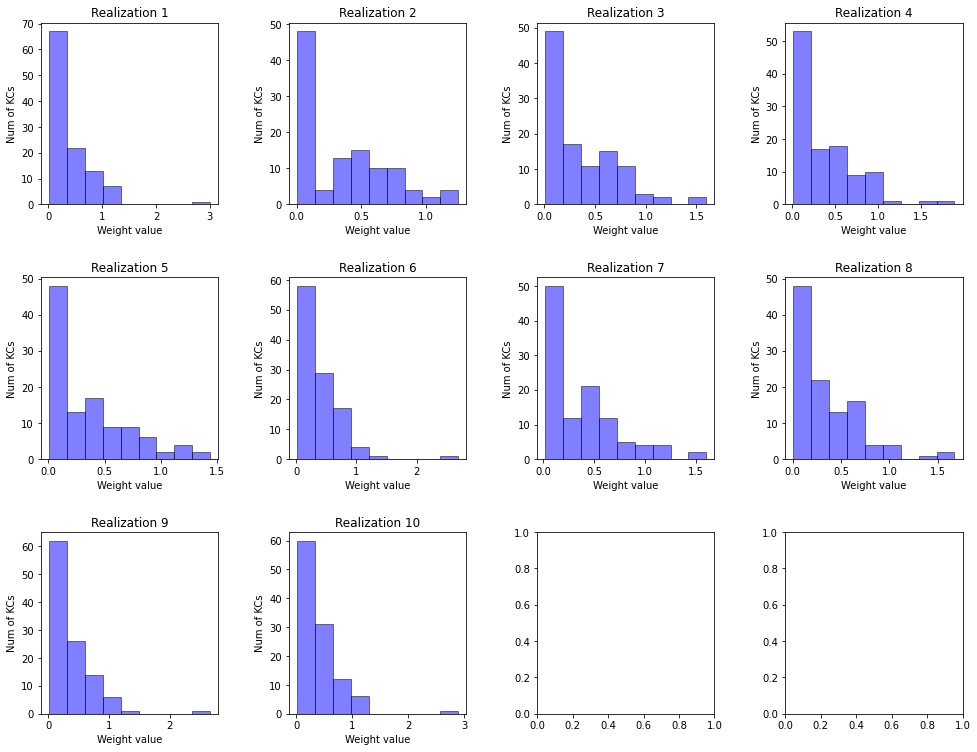

In [8]:
with open('C:/Users/Katherine Xie/RiseProject/run12-remove0KC-wsum2-savedodors/final-weights12.pkl', 'rb') as f:
    all_final_weights = pickle.load(f)
    
# find total weights from 10 sets of final weights
total_weights = np.zeros((10, 110))

for i in range(10):
    total_weights[i] = (abs(all_final_weights[i])).sum(axis=1)

# DISTRIBUTIONS OF SUM OF THE ABSOLUTE VALUE OF KC WEIGHTS FOR EACH REALIZATION
figure, axis = plt.subplots(3, 4, figsize=(16,12))

a = 0
for i in range(3):
    for j in range(4):
        if a < 10:
            # initial weights
            x = total_weights[a]
            axis[i, j].hist(x, bins=np.linspace(x.min(), x.max(), 10), edgecolor='black', color='blue', alpha=0.5)

            axis[i, j].set_title("Realization {}".format(a+1))
            axis[i, j].set_xlabel("Weight value")
            axis[i, j].set_ylabel("Num of KCs")
        
        a += 1

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


plt.show()

<IPython.core.display.Javascript object>


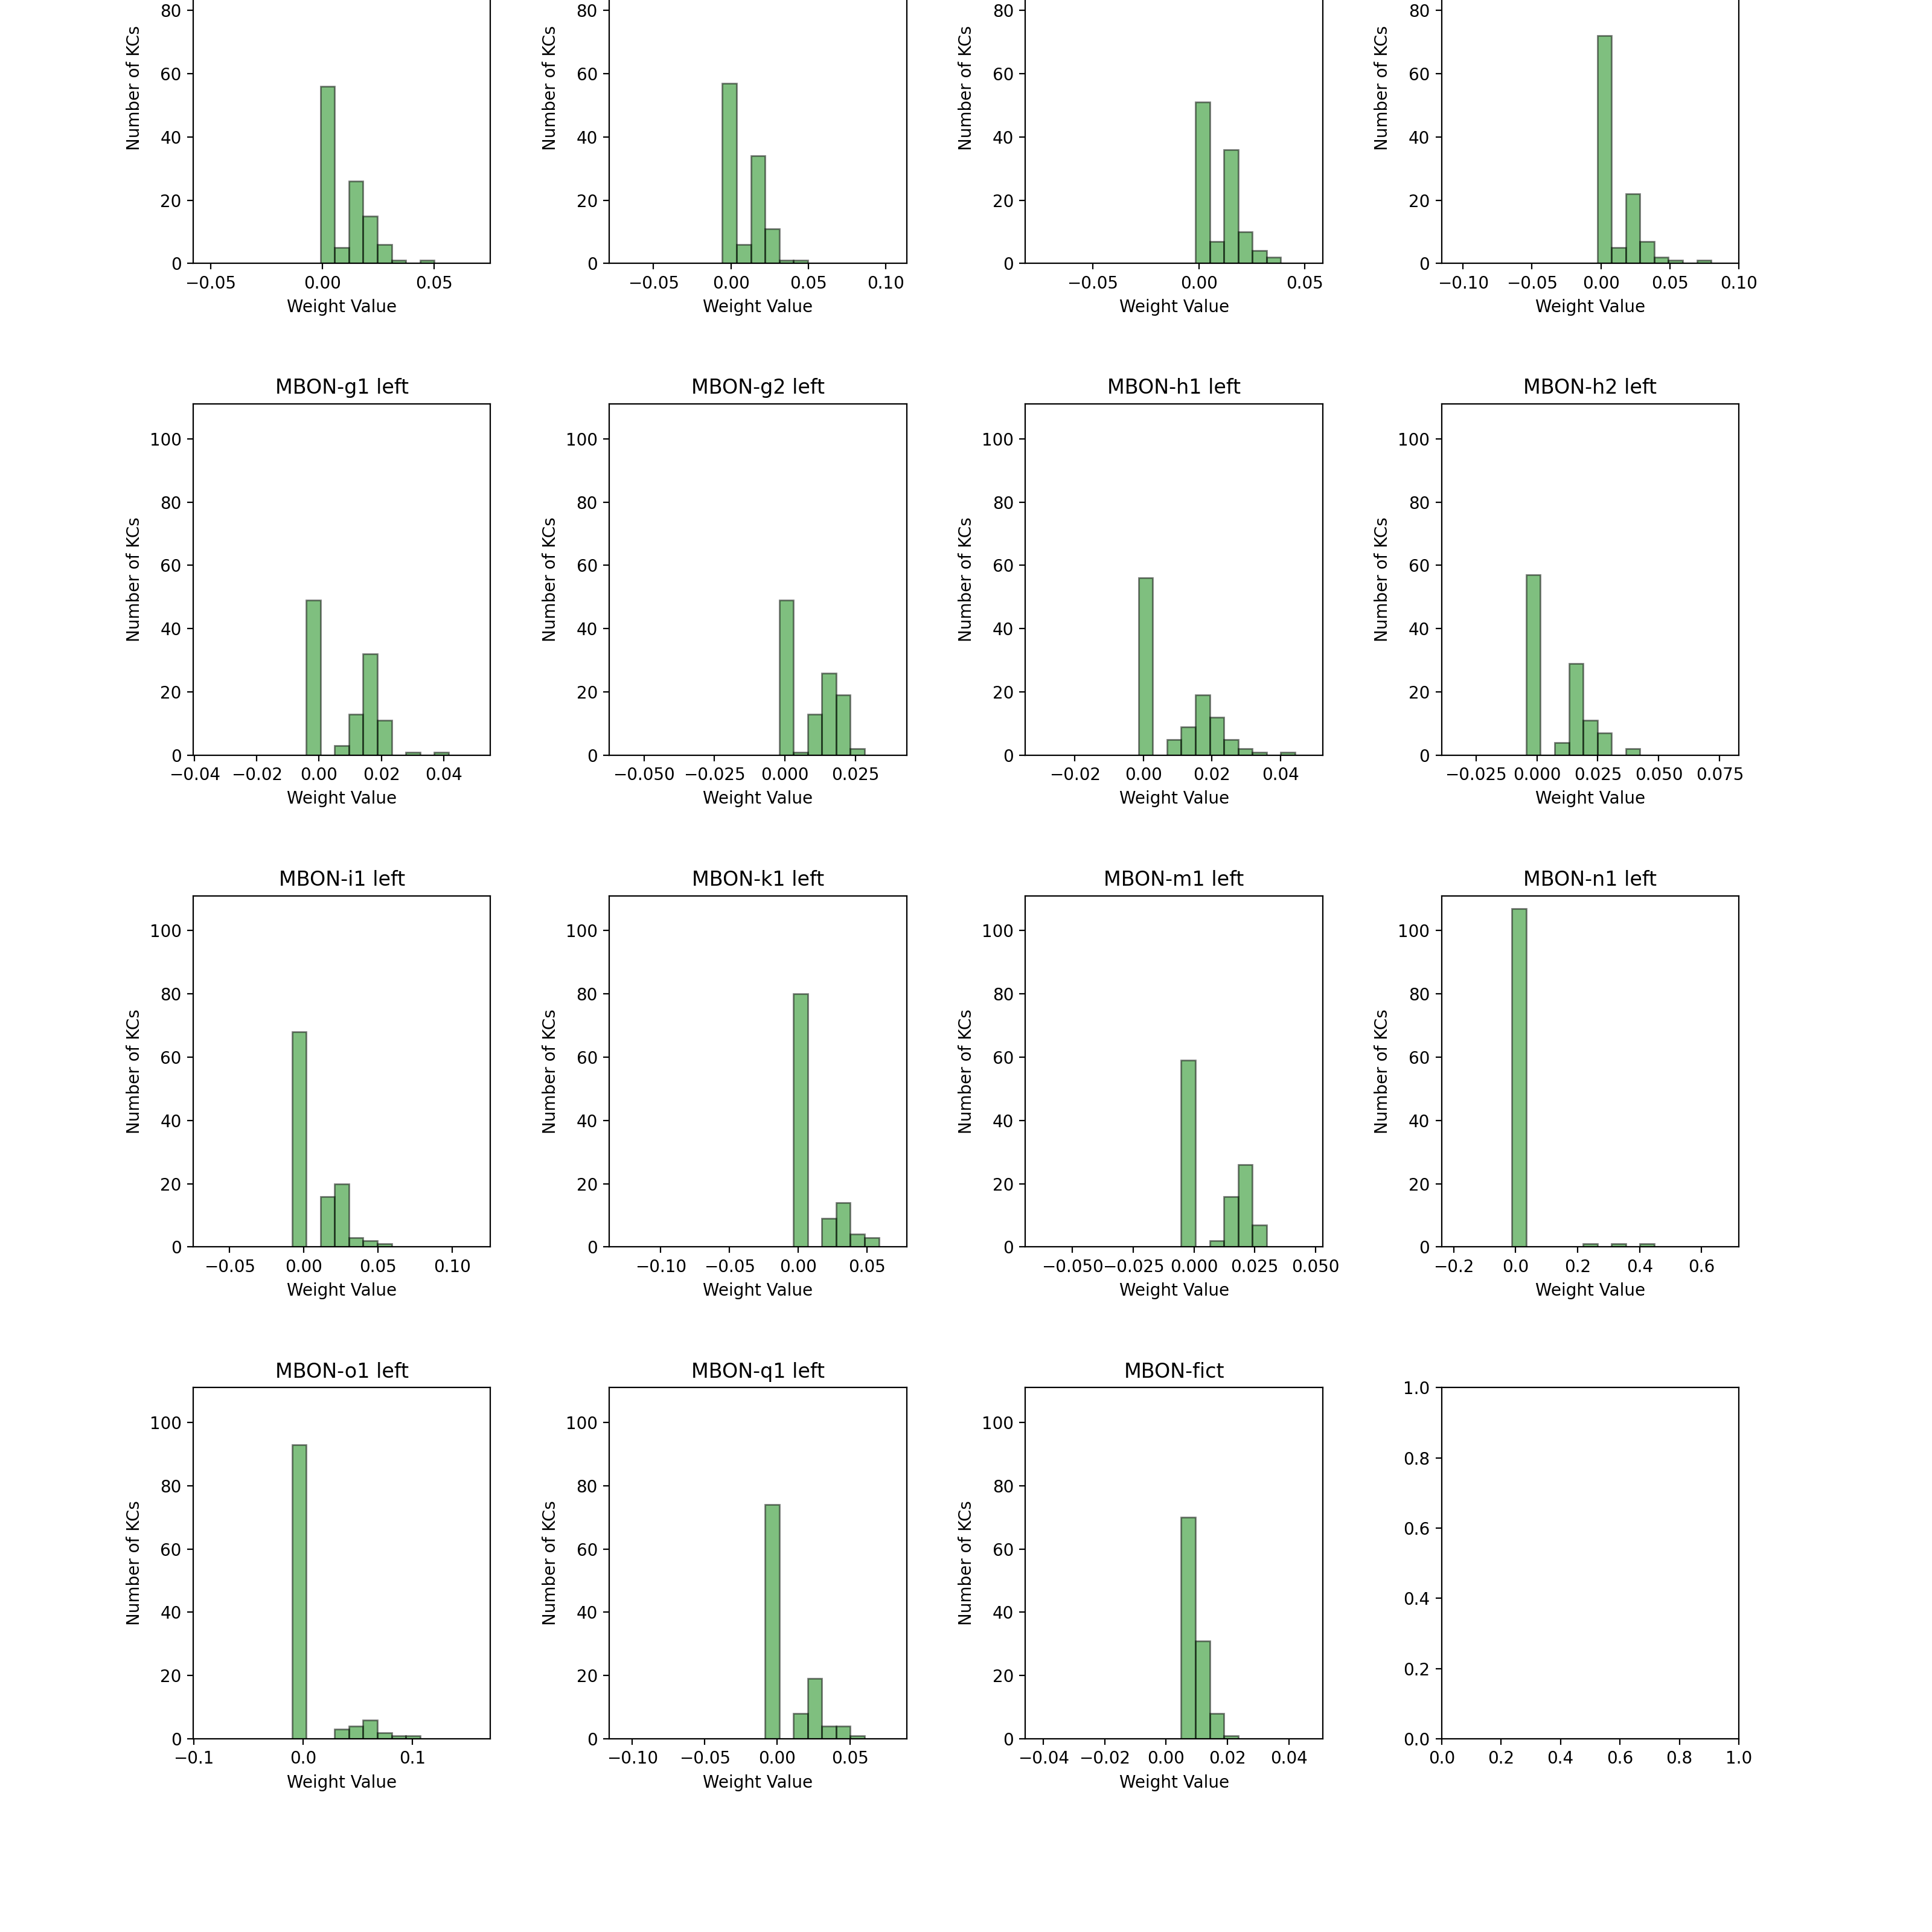

In [212]:
with open('C:/Users/Katherine Xie/RiseProject/run18-control-remove0KC-weightsum1/final-weights18.pkl', 'rb') as f:
    final_weights0 = pickle.load(f)
    
# HISTOGRAM OF THE DISTRIBUTION OF MBON WEIGHTS VS NUM OF KCS
figure, axis = plt.subplots(5, 4, figsize=(16,16))
avg_final_weights = np.mean(abs(final_weights0), axis=0)

a = 0
for i in range(5):
    for j in range(4):
        if (a != 19):
            x = np.zeros((3, num_kcs))
            x[0] = kc_mbon.iloc[:,a]
            x[1] = final_weights[0, :, a]
            x[2] = avg_final_weights[:, a]
            
            # initial weights
#             axis[i, j].hist(x[0], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='blue', alpha=0.5, label='initial')
            
            # after 1 run of training
#             axis[i, j].hist(x[1], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='red', alpha=0.5, label='1 run')
            
            # avg of 10 runs
            axis[i, j].hist(x[2], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='green', alpha=0.5, label='avg over 10')
            
            axis[i, j].set_title(kc_mbon.columns[a])
            axis[i, j].set_ylim(0, 111)
            axis[i, j].set_xlabel('Weight Value')
            axis[i, j].set_ylabel('Number of KCs')
        a += 1
        
axis[0, 0].legend()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

<IPython.core.display.Javascript object>


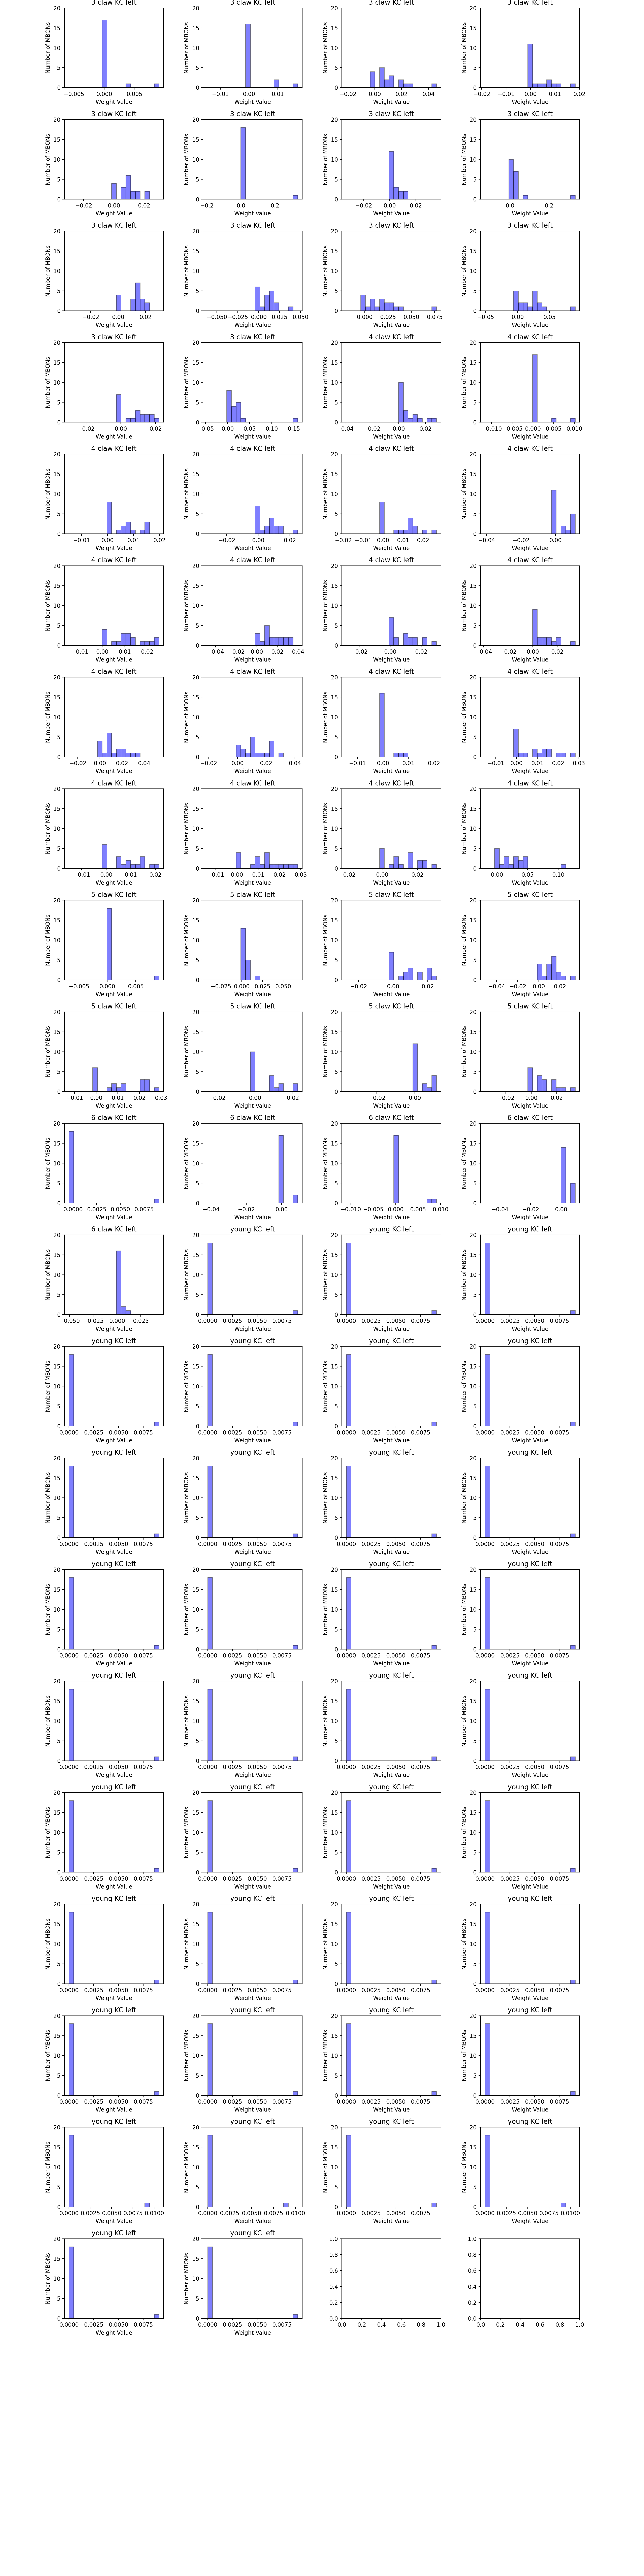

In [210]:
with open('C:/Users/Katherine Xie/RiseProject/run18-control-remove0KC-weightsum1/final-weights18.pkl', 'rb') as f:
    final_weights0 = pickle.load(f)
    
# average final weights over 10
avg_final_weights = np.mean(final_weights0, axis=0)

# HISTOGRAM OF THE DISTRIBUTION OF KC WEIGHTS VS NUM OF MBONS
figure, axis = plt.subplots(28, 4, figsize=(16,64))

a = 0
for i in range(28):
    for j in range(4):
        if a < 110:
            # initial weights
            x = np.zeros((3, num_mbons))
            x[0] = kc_mbon.iloc[a]
            x[1] = final_weights0[0, a]
            x[2] = avg_final_weights[a]

            axis[i, j].hist(x[0], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='blue', alpha=0.5, label='initial')

            # final weights after 1 training run
#             axis[i, j].hist(x[1], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='red', alpha=0.5, label='1 run')

            # final weights avgeraged over 10 training runs
#             axis[i, j].hist(x[2], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='green', alpha=0.5, label='avg over 10')

            axis[i, j].set_title(kc_mbon.index[a])
            axis[i, j].set_xlabel('Weight Value')
            axis[i, j].set_ylabel('Number of MBONs')
            axis[i, j].set_ylim(0, 20)
        
        a += 1

axis[0, 0].legend()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)


plt.show()

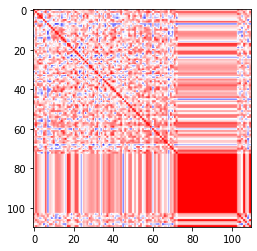

In [34]:
# HEAT MAP OF SPEARMAN CORRELATION COEFFICIENT OF TOTAL WEIGHTS (110 X 110)

total_weight_corr, corr_p = st.spearmanr(total_weights)
plt.figure()
plt.imshow(total_weight_corr, cmap="bwr", clim=(-1,1))

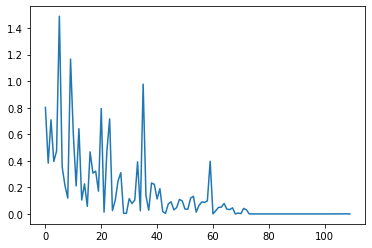

In [41]:
# GRAPH OF KCS VS. VARIANCE IN TOTAL WEIGHTS
new_total_weights = np.concatenate((total_weights[0:7], total_weights[8:10]), axis=0)

total_weight_var = np.var(new_total_weights, axis=0)

plt.figure()
plt.plot(total_weight_var)

In [5]:
fict_weights = np.full(len(kc_mbon), 1) # initializing all weights at 0.1
kc_mbon_orig['MBON-fict'] = fict_weights
kc_mbon_orig

MBON-a1 left  MBON-a2 left  MBON-b1 left  MBON-b2 left  \
Presynaptic KCs                                                           
1 claw KC left              4             5            13             7   
1 claw KC left              8             4            15            15   
1 claw KC left             10             4            10            14   
1 claw KC left             11             5            24            20   
1 claw KC left              3             3            12             8   
...                       ...           ...           ...           ...   
young KC left               0             0             0             0   
young KC left               0             0             0             0   
young KC left               0             0             0             0   
young KC left               0             0             0             0   
young KC left               0             0             0             0   

                 MBON-c1 left  MBON-d1 left  MBON-e1 left  MBON-e2 left  \
Presynaptic KCs                                                           
1 claw KC left             40            10            21             7   
1 claw KC left             27            13            17             3   
1 claw KC left             22             9            12             4   
1 claw KC left             39             9            19             6   
1 claw KC left             63            14             8             0   
...                       ...           ...           ...           ...   
young KC left               0             0             0             0   
young KC left               0             0             0             0   
young KC left               0             0             0             0   
young KC left               0             0             0             0   
young KC left               0             0             0             0   

                 MBON-g1 left  MBON-g2 left  MBON-h1 left  MBON-h2 left  \
Presynaptic KCs                                                           
1 claw KC left              8             7             6            10   
1 claw KC left             16            11             2             7   
1 claw KC left             11             9             6             9   
1 claw KC left             13             4             7            14   
1 claw KC left              4            11             9             7   
...                       ...           ...           ...           ...   
young KC left               0             0             0             0   
young KC left               0             0             0             0   
young KC left               0             0             0             0   
young KC left               0             0             0             0   
young KC left               0             0             0             0   

                 MBON-i1 left  MBON-k1 left  MBON-m1 left  MBON-n1 left  \
Presynaptic KCs                                                           
1 claw KC left              9             0             5             0   
1 claw KC left              5             0             0             0   
1 claw KC left             10             3             2             0   
1 claw KC left              5             0             3             0   
1 claw KC left              5             2             5             0   
...                       ...           ...           ...           ...   
young KC left               0             0             0             0   
young KC left               0             0             0             0   
young KC left               0             0             0             0   
young KC left               0             0             0             0   
young KC left               0             0             0             0   

                 MBON-o1 left  MBON-q1 left  MBON-fict  
Presynaptic KCs                                         

In [6]:
# prints KC connections
num_mbons = 19
print("number of KC connections:")
for j in range(num_mbons):
    conn = kc_mbon_orig.to_numpy()[:,j].sum()
#     if (conn == 0):
    print("{}: {}".format(kc_mbon.columns[j], conn))

number of KC connections:
MBON-a1 left: 280
MBON-a2 left: 438
MBON-b1 left: 354
MBON-b2 left: 356
MBON-c1 left: 1154
MBON-d1 left: 409
MBON-e1 left: 629
MBON-e2 left: 133
MBON-g1 left: 513
MBON-g2 left: 470
MBON-h1 left: 289
MBON-h2 left: 385
MBON-i1 left: 187
MBON-k1 left: 87
MBON-m1 left: 177
MBON-n1 left: 6
MBON-o1 left: 63
MBON-q1 left: 143
MBON-fict: 110


In [10]:
# prints number of presynaptic KCs for each MBON
bool_synapses = np.where(kc_mbon > 0, 1, 0)
print("number of presynaptic KCs:")
for j in range(num_mbons):
    conn = bool_synapses[:,j].sum()
#     if (conn == 0):
    print("{}: {}".format(kc_mbon.columns[j], conn))

number of presynaptic KCs:
MBON-a1 left: 55
MBON-a2 left: 63
MBON-b1 left: 46
MBON-b2 left: 47
MBON-c1 left: 54
MBON-d1 left: 53
MBON-e1 left: 59
MBON-e2 left: 38
MBON-g1 left: 61
MBON-g2 left: 61
MBON-h1 left: 54
MBON-h2 left: 53
MBON-i1 left: 42
MBON-k1 left: 30
MBON-m1 left: 51
MBON-n1 left: 3
MBON-o1 left: 17
MBON-q1 left: 36
MBON-fict: 110


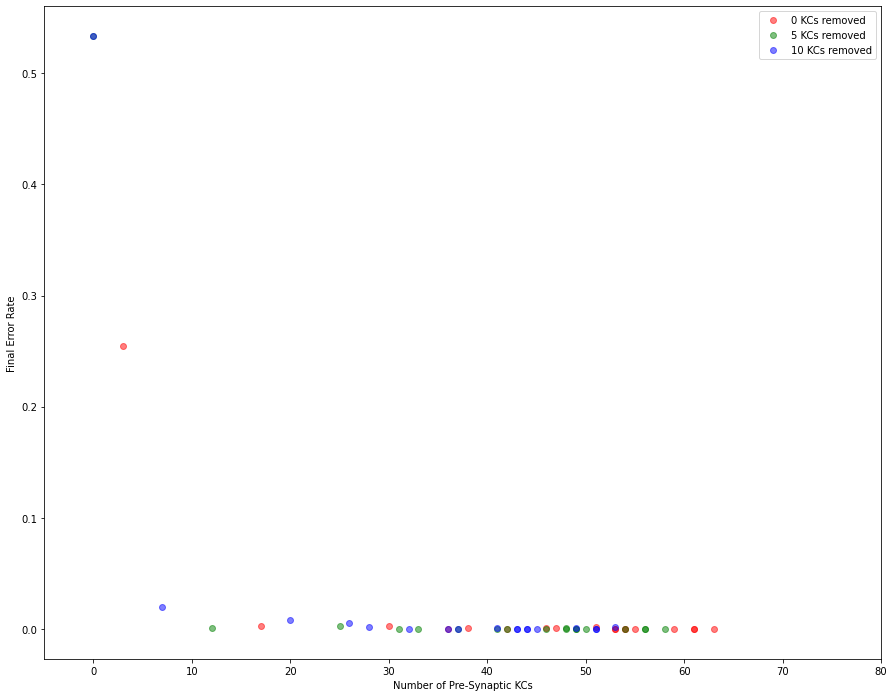

In [20]:
# NUMBER OF PRESYNAPTIC KCS VS. FINAL ERROR RATE (REMOVED 0, 5, 10, 20 KCS)
# FOR ALL -> SUM OF WEIGHTS = 2

plt.figure(figsize=(15,12))
sums = bool_synapses.sum(axis=0)

# 0 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run9-remove0KC/all-error-rates9.pkl', 'rb') as f:
    error_rates_remove0 = pickle.load(f)

avg_error_rates0 = np.mean(error_rates_remove0, axis=0)
x0 = sums # number of synapses
y0 = avg_error_rates0[-1,0:19] # final error rate

plt.plot(x0, y0, 'ro', alpha=0.5, label="0 KCs removed")

# 5 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run8-remove5KC/all-error-rates8.pkl', 'rb') as f:
    error_rates_remove5 = pickle.load(f)

avg_error_rates5 = np.mean(error_rates_remove5, axis=0)
temp = np.where(sums - 5 < 0, 0, sums)
x5 = np.subtract(temp, 5, where=temp>0) # number of synapses
y5 = avg_error_rates5[-1,0:19] # final error rate

plt.plot(x5, y5, 'go', alpha=0.5, label="5 KCs removed")

# 10 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run6-remove10KC/all-error-rates6.pkl', 'rb') as f:
    error_rates_remove10 = pickle.load(f)

avg_error_rates10 = np.mean(error_rates_remove10, axis=0)
temp = np.where(sums - 10 < 0, 0, sums)
x10 = np.subtract(temp, 10, where=temp>0) # number of synapses
y10 = avg_error_rates10[-1,0:19] # final error rate

plt.plot(x10, y10, 'bo', alpha=0.5, label="10 KCs removed")

# # 20 KCs removed
# with open('C:/Users/Katherine Xie/RiseProject/run7-remove20KC/all-error-rates7.pkl', 'rb') as f:
#     error_rates_remove20 = pickle.load(f)

# avg_error_rates20 = np.mean(error_rates_remove20, axis=0)
# temp = np.where(sums - 20 < 0, 0, sums)
# x20 = np.subtract(temp, 20, where=temp>0) # number of synapses
# y20 = avg_error_rates20[-1,0:19] # final error rate

# plt.plot(x20, y20, 'ko', alpha=0.5, label="20 KCs removed")

plt.xlim([-5, 80])
plt.xlabel("Number of Pre-Synaptic KCs")
plt.ylabel("Final Error Rate")
plt.legend()

plt.show()

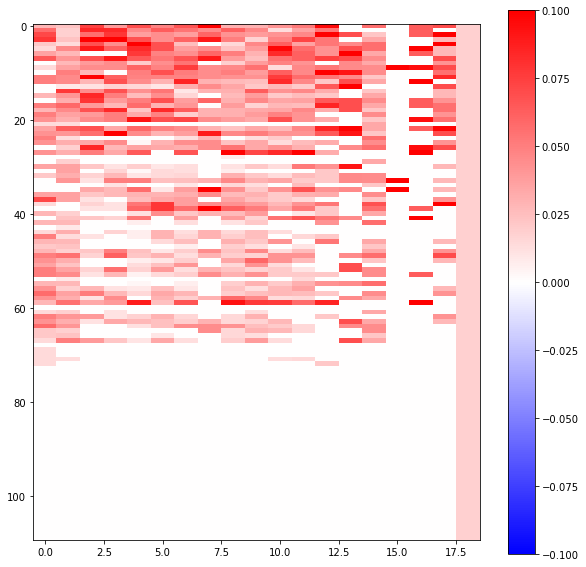

In [27]:
# HEAT MAP OF INITIAL KC WEIGHTS
plt.figure(figsize=(10,10))
c1 = plt.imshow(kc_mbon, cmap="bwr", clim=(-.1,.1), aspect=.2)
plt.colorbar(c1)
plt.show()

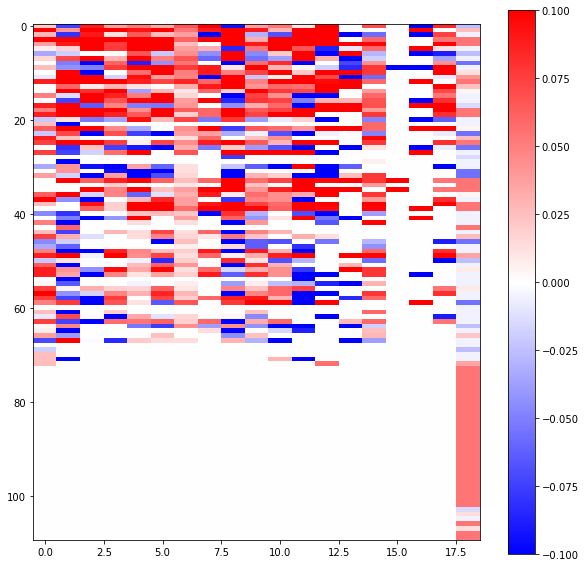

In [28]:
# HEAT MAP OF FINAL KC WEIGHTS AFTER 1 TRAINING RUN
plt.figure(figsize=(10,10))
c2 = plt.imshow(all_kc_weights[0], cmap="bwr", clim=(-.1,.1), aspect=.2)
plt.colorbar(c2)
plt.show()

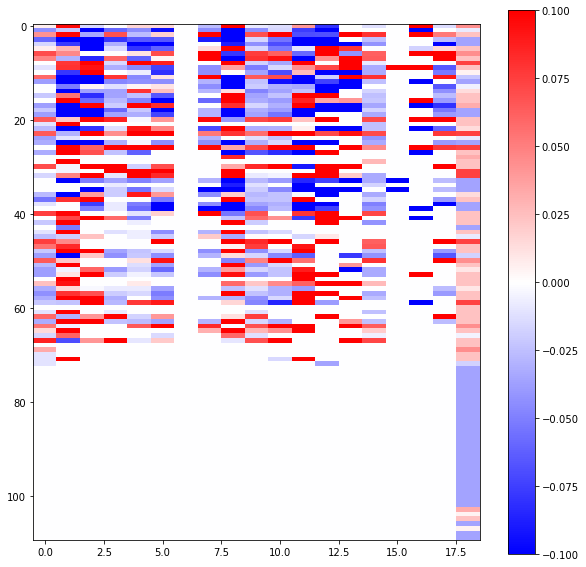

In [26]:
# HEAT MAP OF DIFFERENCE BETWEEN INITIAL AND FINAL WEIGHTS AFTER 1 TRAINING RUN
plt.figure(figsize=(10,10))
c3 = plt.imshow(kc_mbon - all_kc_weights[0], cmap="bwr", clim=(-.1,.1), aspect=.2)
plt.colorbar(c3)
plt.show()

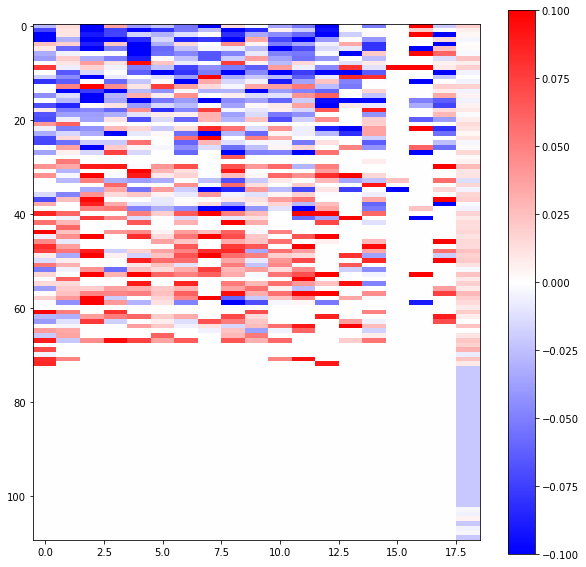

In [30]:
# HEAT MAP OF THE DIFFERENCE BETWEEN INITIAL AND AVG FINAL WEIGHTS (OF 10 TRAINING RUNS)
plt.figure(figsize=(10,10))
average_weights = np.mean(all_kc_weights, axis=0)
c3 = plt.imshow(kc_mbon - average_weights, cmap="bwr", clim=(-.1,.1), aspect=.2)
plt.colorbar(c3)
plt.show()

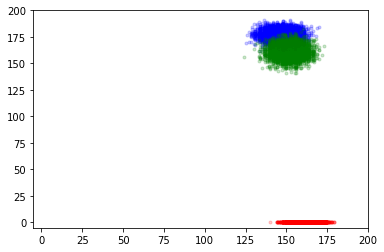

In [41]:
# GENERATING ODORS
# for running with new odors
spikes = 200
bool_response = np.random.binomial(1, 0.5, (N, num_pns))  # .5 probability - https://journals.physiology.org/doi/full/10.1152/jn.01283.2007   
probability = np.random.normal(0.8, 0.05, (N, num_pns)) # center, std, size
response = np.multiply(bool_response, probability)

# generating input points
all_inputs = np.zeros((num_inputs, num_pns)) # 2D input array used for neural network
odor_idx = num_inputs//N
pn_inputs = np.zeros((N, num_inputs//N, num_pns)) # 3D inputs separated by odor
for n in range(N):
    inputs = np.random.binomial(spikes, response[n], size=(num_inputs//N, num_pns))
    all_inputs[n*odor_idx:odor_idx*(n + 1)] = inputs
    pn_inputs[n] = inputs

# # record input distributions
# total_inputs = all_inputs
# total_inputs_3D = pn_inputs

# # for running with same odors
# all_inputs = total_inputs
# pn_inputs = total_inputs_3D

# plot input distributions
plt.figure()
for i in range(N):
    plt.plot(pn_inputs[i, :, 2], pn_inputs[i, :, -3], '.', alpha = 0.2)
plt.xlim(-5, 200)
plt.ylim(-5, 200)

plt.show()

# target outputs for each odor
odor_outputs = np.zeros((N, num_mbons))
for i in range(N):
    odor_outputs[i] = np.random.randint(0, 2, num_mbons)

target_outputs = np.full((num_inputs, num_mbons), odor_outputs[0]) # array of target outputs used for training
for i in range(N):
    target_outputs[i*num_inputs//N:] = odor_outputs[i]